D:\AFT\Feature_Engineer_Kaggle_2025\Factors\cross_section_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\ipynb_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\market_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\rank9_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\Factors\timeseries_features.parquet


In [ ]:
import os
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn as sk
import lightgbm
SEED = 42
os.chdir(r'D:\AFT\Feature_Engineer_Kaggle_2025')
import numpy as np
import pandas as pd
import os
base_path = r'D:\AFT\Feature_Engineer_Kaggle_2025\Factors'  # 原始字符串
# 检查路径是否存在
if os.path.exists(base_path):
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print(f"路径不存在: {base_path}")

In [ ]:
# 数据预处理
cross_section_features = pd.read_parquet(os.path.join(dirname, "cross_section_features.parquet")).iloc[:1000000]
X_train = cross_section_features.query("target.notna()").drop(['row_id'], axis=1)
y_train = X_train.pop("target")
# 删除包含NaN的列
X_train.drop(['wap_y', 'mid_price_y'], axis=1, inplace=True)
# 处理inf值
cols_contain_inf = (
    X_train
    .select_dtypes("float")
    .columns[
        np.isinf(
            X_train.select_dtypes("float")
        ).sum() != 0
    ]
)
X_train[cols_contain_inf] = (
    X_train
    [cols_contain_inf]
    .mask(
        np.isinf(X_train[cols_contain_inf])
    )
)
(X_train
    .select_dtypes("float")
    .columns
    [
        np.isinf(
            X_train
            .select_dtypes("float")
        ).sum()!=0
    ])

In [2]:
#import pandas as pd
X_train= pd.read_parquet(r"C:\Users\47318\Desktop\feature importance\X_train.parquet")
y_train = pd.read_pickle(r"C:\Users\47318\Desktop\feature importance\y_train.pkl")
X_train= X_train[:10000]
y_train= y_train[:10000]

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 按时间序列分割数据 - 使用 date_id 作为时间标识
def time_based_split(X, y, test_size=0.2, val_size=0.15):
    sorted_indices = X.sort_values(by=['date_id', 'seconds_in_bucket']).index
    X_sorted = X.loc[sorted_indices]
    y_sorted = y.loc[sorted_indices]
    total_size = len(X_sorted)
    train_end = int(total_size * (1 - test_size - val_size))
    val_end = int(total_size * (1 - test_size))
    X_train = X_sorted.iloc[:train_end]
    y_train = y_sorted.iloc[:train_end]
    X_val = X_sorted.iloc[train_end:val_end]
    y_val = y_sorted.iloc[train_end:val_end]
    X_test = X_sorted.iloc[val_end:]
    y_test = y_sorted.iloc[val_end:]
    return X_train, X_val, X_test, y_train, y_val, y_test

# 执行时间序列分割
X_train, X_val, X_test, y_train, y_val, y_test = time_based_split(X_train, y_train)
# 从特征中移除时间标识列
feature_columns = [col for col in X_train.columns if col not in ['stock_id', 'date_id', 'seconds_in_bucket']]
train_data = lgb.Dataset(
    X_train[feature_columns], 
    label=y_train,
    feature_name=feature_columns,
    free_raw_data=False
)
val_data = lgb.Dataset(
    X_val[feature_columns], 
    label=y_val,
    feature_name=feature_columns,
    free_raw_data=False,
    reference=train_data
)

# LightGBM参数配置 - 重点防止过拟合
params = {
    'objective': 'regression',  # 如果是分类问题改为 'binary' 或 'multiclass'
    'metric': 'rmse',  # 根据任务调整：mae, mse, rmse, binary_logloss, multi_logloss等
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,  # 控制模型复杂度，防止过拟合
    'max_depth': -1,   # -1表示无限制，可以设置为较小值如7-10防止过拟合
    'min_data_in_leaf': 20,  # 叶节点最小数据量，防止过拟合
    'min_sum_hessian_in_leaf': 1e-3,  # 防止过拟合
    'feature_fraction': 0.8,  # 特征采样比例
    'bagging_fraction': 0.8,  # 数据采样比例
    'bagging_freq': 5,
    'lambda_l1': 0.1,  # L1正则化
    'lambda_l2': 0.1,  # L2正则化
    'verbosity': -1,
    'seed': 42
}
# 训练模型 with 早停
print("开始训练LightGBM模型...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=10000,  # 设置较大的轮数，让早停机制决定停止
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),  # 早停
        lgb.log_evaluation(100),  # 每100轮打印一次评估结果
    ]
)

print(f"最佳迭代轮数: {model.best_iteration}")
print(f"最佳验证分数: {model.best_score}")
test_predictions = model.predict(X_test[feature_columns])
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
print(f"\n测试集表现:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
# 特征重要性分析
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

print("\n前10重要特征:")
print(feature_importance.head(10))


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 1. 训练模型
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train)

SHAP

# **1. SHAP 原理概述**

SHAP 是一种解释机器学习模型的方法，核心思想来自**合作博弈论的 Shapley Value（沙普利值）**。

> **目标：** 判断每个特征在预测中“贡献了多少”。

一般特征重要性方法只能告诉你“哪些特征更重要”，而 **SHAP 不仅能表达重要性，还能告诉你贡献方向（正/负）和贡献大小（定量）**。

# **2. 理论基础：Shapley Value（沙普利值）**

### **📌 SHAP 来源于博弈论**

在合作博弈论中，如果多个玩家一起完成任务，可使用 Shapley Value 计算每个人的**公平贡献值**。

在 SHAP 中：

- **玩家 = 每个特征**
- **任务 = 预测某个样本的输出**
- **贡献 = 特征对预测结果的影响**

### **📌 Shapley Value 数学定义（直观）**

对某个特征 i，其 Shapley Value 是：

> 在所有可能的特征加入顺序中，特征 i 在加入前后造成的边际提升的平均值。

数学式：
$$
\phi_i = \sum_{S \subseteq F\setminus\{i\}} \frac{|S|!\,(|F|-|S|-1)!}{|F|!}\left[f(S\cup \{i\}) - f(S)\right]
$$
解释：

- 枚举所有特征组合 S，计算加入特征 i 前后模型输出的变化
- 使用阶乘来保证“公平加权”

# **3. SHAP 的计算过程**

实际 Shapley Value 的计算非常昂贵（指数级复杂度），因此 SHAP 提供不同模型的优化方案。

### **3.1 通用流程（理论）**

对每个特征 i ：

1. 枚举所有特征加入的可能顺序

2. 对每一个顺序，计算：
   $$
   \Delta = f(\text{加入 i 后}) - f(\text{加入 i 前})
   $$
   

3. 将所有顺序的贡献取平均

### **3.2 实际实现（按模型类型）**

| **计算方法**      | **适用模型**                               | **速度** | **精确度**            |
| ----------------- | ------------------------------------------ | -------- | --------------------- |
| **TreeSHAP**      | XGBoost、LightGBM、CatBoost、Random Forest | 很快     | 精确（无采样）        |
| **KernelSHAP**    | 任何模型                                   | 慢       | 近似（采样）          |
| **LinearSHAP**    | 线性模型                                   | 快       | 精确                  |
| **DeepSHAP**      | 神经网络                                   | 中等     | 近似（基于 DeepLIFT） |
| **GradientSHAP**  | 深度学习                                   | 中等     | 近似（基于噪声梯度）  |
| **PartitionSHAP** | 特征有结构依赖时                           | 中等     | 精确                  |
| **Sampling SHAP** | 任何模型                                   | 很慢     | 近似                  |

由于这里原始SHAP（尤其 KernelSHAP）需要反复计算“移除特征后的模型输出”，非常慢，所以提出了**一阶展开的SHAP**，是对SHAP的一种近似。用来：

- 加快深度模型的 SHAP 计算
- 解决不可移除特征的 Shapley Value 估计问题

# Tree SHAP

**TreeSHAP 不存在“一阶展开版本”（gradient-based SHAP）**，而且 **即使做一阶展开，也不会比标准 TreeSHAP 更快**

- 专门为 **树模型（GBDT、随机森林）** 优化

- **精确**计算 Shapley Value

- 时间复杂度降低到：

  O(TLD^2)

  T=树数量，L=叶子数量，D=树深度

- 使用动态规划分析每个样本如何在树中传播

这是唯一既快又精确的 SHAP。

树模型有几个关键性质：

1. **每个样本在树中走的是一条路径**
2. 每条路径的叶子对应一个固定预测值
3. 路径上的每个节点的条件可用“特征约束”表示

TreeSHAP 利用这些性质，将 Shapley Value 转化为：

> 样本从根节点到叶子路径中，每个特征对“到达该叶子”贡献多少。

**1）路径（Path）**

样本从根到叶节点的路径中，包含若干 split 节点。

每个 split 节点对应一个特征限制（如 x1 < 5）。

**2）条件概率（p）：特征是否被使用的概率**

对于某个特征若被移除（缺失）：

- 树无法判断去左还是右
- 需要根据训练数据中那条边的样本比例进行概率分配

**3）动态规划：路径权重累积机制**

TreeSHAP 用动态规划存储：

- path_unique_features = 路径上出现的特征
- path_zero_fraction = 在特征移除时走这条路径的概率
- path_one_fraction = 在特征加入时走这条路径的概率
- path_weight = 权重（基于 Shapley 的组合系数）

最终每个特征的 SHAP 值为：
$$
\phi_i = \sum_{\text{每个叶子}} (\text{叶子输出值} - \text{期望值}) \times \text{路径上 i 的贡献权重}
$$
对于任意树的一个叶子 l：
$$
\phi_i = \sum_{l} \text{LeafValue}(l) \sum_{S\subseteq F\setminus\{i\}} \text{Prob}(S\to l) \cdot \big[\text{Prob}(i\in path) - \text{Prob}(i\notin path)\big]
$$
TreeSHAP 实际不会枚举 S，而是通过 DP 算法高效计算上面的概率。

**步骤 1：对每棵树进行遍历**

对样本所在路径执行动态规划计算。

**步骤 2：递归遍历所有节点**

每访问一个 split 节点：

1. 判断样本走左还是右
2. 计算 zero_fraction、one_fraction
3. 将该节点的“特征约束”添加到路径

**步骤 3：到达叶子节点时**

根据路径：

- 计算每个特征在该叶子的“边际贡献”
- 加权求和累加到 SHAP 值

这一部分是算法最难的地方，但 TreeSHAP 使用 DP 进行高效权重计算。

# **4. SHAP 的优势（为什么强大）**

### **✅ 1. 有理论保证的“公平性”**

Shapley Value 是唯一满足以下四个公理的解释法：

- 效率（贡献之和等于预测差值）
- 对称性
- 空贡献
- 可加性

**使得解释更严谨、公平。**

### **✅ 2. 输出具有可解释维度：大小 + 正负方向**

- SHAP 值大 → 对预测影响大
- SHAP 值为正 → 推高预测
- SHAP 值为负 → 拉低预测

等价于给出：

- 影响程度
- 影响方向
- 针对单个样本的解释

### **✅ 3. 可解释单个样本（局部解释）**

例如解释“为什么某个用户会被判定高风险”。

### **✅ 4. 可解释整体特征重要性（全局解释）**

可视化工具包括：

- summary_plot
- dependence_plot
- force_plot
- waterfall_plot

### **✅ 5. 可处理非线性模型**

即使模型非常复杂，也能提供一致的解释。



# **🔶 5. SHAP 的缺点（什么时候需要谨慎）**

### **❌ 1. KernelSHAP 计算成本高（尤其高维特征）**

高维模型可能花费数十分钟甚至数小时。

### **❌ 2. 对特征强相关时解释存在偏差**

因为 Shapley Value 假设“特征独立”，实际数据中常常不满足。

例如两个高度相关的特征，会导致 SHAP 难以公平分配贡献。

### **❌ 3. baseline / reference 选择对解释影响大**

特别是深度学习模型中，“基线输入”的选择会显著影响 SHAP 值。

# **6. SHAP 与传统特征重要性方法对比**

下面筛选几个常见方法做系统对比。

## ** 6.1 与模型自带的重要性（如 XGBoost importance）对比**

| **方法**                   | **说明**                   | **SHAP 的优势**              |
| -------------------------- | -------------------------- | ---------------------------- |
| **Gain importance**        | 特征在分裂中提供的信息增益 | 无法解释方向，也有偏差       |
| **Split count**            | 特征被使用次数             | 不体现贡献大小               |
| **Permutation importance** | 打乱特征看性能下降情况     | 全局性强，但无法解释单个样本 |

**SHAP 的优势：**

- 理论更严谨
- 可解释单个样本
- 显示方向（正/负）
- 有公理支持公平性

## **6.2 与 LIME 对比**

| **项目** | **SHAP**         | **LIME**             |
| -------- | ---------------- | -------------------- |
| 稳定性   | 稳定（理论保证） | 不稳定（采样随机性） |
| 局部解释 | 强               | 强                   |
| 全局解释 | 有（summary）    | 无                   |
| 计算成本 | 较高             | 较低                 |
| 理论基础 | 严格（博弈论）   | 近似线性拟合         |

 **结论**：LIME 更快，SHAP 更严谨、解释更可靠。

## **6.3 与 Permutation Importance 对比**

| **项目**   | **SHAP**    | **Permutation**        |
| ---------- | ----------- | ---------------------- |
| 粒度       | 全局 + 局部 | 全局                   |
| 是否有方向 | 有          | 无                     |
| 是否公平   | 公平        | 容易受到特征相关性干扰 |
| 计算成本   | 中-高       | 低                     |

In [ ]:
def shap_compare(model, X_train, K=50):

    import numpy as np
    import pandas as pd
    import time
    import shap
    import matplotlib.pyplot as plt
    from scipy.stats import spearmanr

    # ====================== 参数处理 ======================
    N = min(100000, len(X_train))   
    X_sample = X_train[:N]

    if isinstance(X_sample, pd.DataFrame):
        feature_names = X_sample.columns
    else:
        feature_names = [f"f{i}" for i in range(X_sample.shape[1])]
        X_sample = pd.DataFrame(X_sample, columns=feature_names)

    # ====================== 1. full SHAP (LightGBM 内置) ======================
    t0 = time.time()
    shap_full = model.predict(
        X_sample,
        pred_contrib=True,
        approximate=True,
        num_iteration=None 
    )
    shap_full = shap_full[:, :-1]  # 去掉 bias
    t1 = time.time()

    # ====================== 2. K SHAP (LightGBM 内置) ======================
    t2 = time.time()
    shap_k = model.predict(
        X_sample,
        pred_contrib=True,
        approximate=True,
        num_iteration=K
    )
    shap_k = shap_k[:, :-1]
    t3 = time.time()

    # ====================== 3. SHAP 包 TreeExplainer ======================
    t4 = time.time()
    explainer = shap.TreeExplainer(model)
    shap_values_shap = explainer.shap_values(X_sample)
    t5 = time.time()

    if isinstance(shap_values_shap, list):  # 二分类
        shap_values_shap = shap_values_shap[1]

    # ====================== 4. 特征重要性对比 ======================
    imp_full = np.mean(np.abs(shap_full), axis=0)
    imp_k = np.mean(np.abs(shap_k), axis=0)
    imp_shap = np.mean(np.abs(shap_values_shap), axis=0)

    df_imp = pd.DataFrame({
        "feature": feature_names,
        "full_shap": imp_full,
        f"k{K}_shap": imp_k,
        "shap_package": imp_shap
    })

    df_imp["rank_full"] = df_imp["full_shap"].rank(ascending=False)
    df_imp[f"rank_k{K}"] = df_imp[f"k{K}_shap"].rank(ascending=False)
    df_imp["rank_shap"] = df_imp["shap_package"].rank(ascending=False)

    df_imp["rank_diff_k"] = df_imp["rank_full"] - df_imp[f"rank_k{K}"]
    df_imp["rank_diff_shap"] = df_imp["rank_full"] - df_imp["rank_shap"]

    df_imp = df_imp.sort_values("rank_full").reset_index(drop=True)

    # ====================== 打印速度结果 ======================
    print("======= 速度对比（秒） =======")
    print(f"1. Full SHAP (LightGBM内置): {t1 - t0:.3f} s")
    print(f"2. K={K} SHAP (LightGBM内置): {t3 - t2:.3f} s")
    print(f"3. SHAP包 TreeExplainer: {t5 - t4:.3f} s")
    print(f"加速倍率 (Full vs K={K}): {(t1 - t0)/(t3 - t2):.2f}x")
    print(f"加速倍率 (SHAP包 vs K={K}): {(t5 - t4)/(t3 - t2):.2f}x")

    # ====================== 前 20 特征 ======================
    print("\n======= 前 20 个特征的重要性对比 =======")
    display(df_imp.head(20))

    # ====================== 5. SHAP 相关性分析 ======================
    print("\n======= 方法间相关性 =======")
    correlation_matrix = df_imp[['full_shap', f'k{K}_shap', 'shap_package']].corr()
    print(correlation_matrix)

    # ====================== 6. 排名相关性 ======================
    spearman_full_k, _ = spearmanr(df_imp["rank_full"], df_imp[f"rank_k{K}"])
    spearman_full_shap, _ = spearmanr(df_imp["rank_full"], df_imp["rank_shap"])
    spearman_k_shap, _ = spearmanr(df_imp[f"rank_k{K}"], df_imp["rank_shap"])

    print("\n======= 排名一致性 (Spearman相关系数) =======")
    print(f"Full SHAP vs K={K} SHAP: {spearman_full_k:.4f}")
    print(f"Full SHAP vs SHAP包: {spearman_full_shap:.4f}")
    print(f"K={K} SHAP vs SHAP包: {spearman_k_shap:.4f}")

    # ====================== 7. 可视化对比 ======================
    top_features = df_imp.head(10)['feature'].values
    top_indices = [list(feature_names).index(f) for f in top_features]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].barh(range(10), imp_full[top_indices])
    axes[0].set_title('Full SHAP (LightGBM)')
    axes[0].set_yticks(range(10))
    axes[0].set_yticklabels(top_features)

    axes[1].barh(range(10), imp_k[top_indices])
    axes[1].set_title(f'K={K} SHAP (LightGBM)')
    axes[1].set_yticks(range(10))
    axes[1].set_yticklabels(top_features)

    axes[2].barh(range(10), imp_shap[top_indices])
    axes[2].set_title('SHAP Package')
    axes[2].set_yticks(range(10))
    axes[2].set_yticklabels(top_features)

    plt.tight_layout()
    plt.show()

    return df_imp


In [ ]:
shap_result = shap_compare(model, X_train, K=50)

gain重要性的计算原理与决策树的构建过程紧密相关。决策树在选择分裂节点时，会寻找一个特征和分裂点，使得分裂后的损失函数减小得最多。这个损失函数的减小量，就称为“增益(Gain)”。

gain重要性的计算方法是：一个特征的重要性等于每次它被用于分裂节点时所带来的信息增益的总和。

具体来说，计算过程如下：

遍历模型中的每一棵决策樹。
在每棵树中，遍历所有使用特定特征（例如特征A）进行分裂的节点。
对于每一个这样的节点，计算分裂操作带来的信息增益。在GBDT中，这个增益通常是分裂后两个子节点的损失之和相较于父节点损失的减少量。（对于分类问题，可能是基尼不纯度或熵的减少；对于回归问题，可能是方差的减少）。
将特征A在所有树中产生的所有增益值累加起来，得到特征A的总gain值。
最后，同样进行归一化处理。
通俗理解： gain衡量的是一个特征的“贡献度”或“决策质量”。一个特征每次分裂带来的性能提升越大，模型就认为它越重要。它关心的不是分裂了多少次，而是每次分裂的效果有多好。

3.2 示例

假设模型有两棵树， এবং每次分裂的增益如下：

树1:
特征A分裂1次，带来增益 50.0。
特征B分裂2次，分别带来增益 5.0 和 6.0。
树2:
特征A分裂2次，分别带来增益 2.0 和 3.0。
特征C分裂1次，带来增益 30.0。
那么各个特征的gain重要性（未归一化）为：

特征A: 50.0 + 2.0 + 3.0 = 55.0
特征B: 5.0 + 6.0 = 11.0
特征C: 30.0
在这个例子中，虽然特征A和特征B的分裂次数一样（都是3次），但特征A的gain重要性远高于特征B，因为它贡献了一次效果极佳的分裂（增益50.0）。

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
def plot_lgbm_gain_split_importance(X_train, y_train, top_n=20, lgb_params=None):
    """
    训练一个 LGBMRegressor，输出 gain 与 split 两种重要性前 top_n 的对比图。
    
    参数
    ----
    X_train : pd.DataFrame 或 np.ndarray
    y_train : 一维 array-like
    top_n   : 显示前多少个特征
    lgb_params : dict，可选 LightGBM 参数（不传则用默认）
    
    返回
    ----
    merged_importance : pd.DataFrame，包含 gain / split / 归一化后的重要性
    """
    # 处理特征名
    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns.tolist()
    else:
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]
        X_train = pd.DataFrame(X_train, columns=feature_names)

    if lgb_params is None:
        lgb_params = dict(
            boosting_type='gbdt',
            num_leaves=31,
            max_depth=-1,
            learning_rate=0.1,
            n_estimators=200,
            subsample=1.0,
            colsample_bytree=1.0,
            reg_alpha=0.0,
            reg_lambda=0.0,
            random_state=42,
            n_jobs=-1,
        )

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_train, y_train)

    booster = model.booster_
    gain = booster.feature_importance(importance_type='gain')
    split = booster.feature_importance(importance_type='split')

    merged_importance = pd.DataFrame({
        'feature': feature_names,
        'gain': gain,
        'split': split
    }).set_index('feature')

    # 归一化方便对比
    merged_importance['gain_normalized'] = merged_importance['gain'] / merged_importance['gain'].max()
    merged_importance['split_normalized'] = merged_importance['split'] / merged_importance['split'].max()
    merged_importance['gain_rank'] = merged_importance['gain'].rank(ascending=False)
    merged_importance['split_rank'] = merged_importance['split'].rank(ascending=False)

    rank_correlation = merged_importance['gain_rank'].corr(merged_importance['split_rank'], method='spearman')

    print(f'\n--- 特征重要性分析 ---\n')
    print(f"Spearman Rank Correlation (Gain vs Split): {rank_correlation:.4f}")

    # 打印排名前 5 的特征对比
    print("\n--- Top 5 Features by Gain vs Split ---\n")
    top_5_gain = merged_importance.sort_values(by='gain', ascending=False).index[:5].tolist()
    top_5_split = merged_importance.sort_values(by='split', ascending=False).index[:5].tolist()

    print(f"Top 5 Features (Gain):  {top_5_gain}")
    print(f"Top 5 Features (Split): {top_5_split}")

    # 找到只在其中一个列表中出现的特征 (差异)
    unique_to_gain = set(top_5_gain) - set(top_5_split)
    unique_to_split = set(top_5_split) - set(top_5_gain)

    if unique_to_gain or unique_to_split:
        print("\n差异分析：")
        print(f"  仅在 Gain Top 5 中出现: {unique_to_gain if unique_to_gain else '无'}")
        print(f"  仅在 Split Top 5 中出现: {unique_to_split if unique_to_split else '无'}")
    else:
        print("\n差异分析：Top 5 特征完全一致。")
    # 取前 top_n
    top_features = merged_importance.sort_values('gain', ascending=False).head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='gain_normalized',
        y=top_features.index,
        data=top_features,
        label='Gain (Normalized)',
        alpha=0.8
    )
    sns.barplot(
        x='split_normalized',
        y=top_features.index,
        data=top_features,
        label='Split (Normalized)',
        alpha=0.6
    )

    plt.title(f'LightGBM Top {top_n} Feature Importance (Gain vs Split, Normalized)', fontsize=16)
    plt.xlabel('Normalized Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return merged_importance


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression


def plot_xgb_importance_norm_3cols(X_train, y_train, top_n=30, xgb_params=None):
    """
    3列输出版本：
    - XGBoost Gain / Cover
    - Mutual Information (MI)
    - 绘制 MI / Gain / Cover 三子图
    - 热力图（Gain / Cover / MI）
    """

    feature_names = list(X_train.columns)

    # ======================================================
    # 默认 XGBoost 参数
    # ======================================================
    if xgb_params is None:
        xgb_params = dict(
            n_estimators=2000,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.5,
            reg_lambda=5.0,
            min_child_weight=5,
            gamma=0.2,
            random_state=42,
            objective='reg:absoluteerror',
            eval_metric='mae',
            tree_method='hist',
            grow_policy='lossguide'
        )

    # ======================================================
    # 训练 XGBoost
    # ======================================================
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)

    booster = model.get_booster()
    imp_gain_dict = booster.get_score(importance_type='gain')
    imp_cover_dict = booster.get_score(importance_type='cover')

    # ======================================================
    # f0,f1,f2 → feature name 映射
    # ======================================================
    def map_features(imp_dict):
        keys = list(imp_dict.keys())
        if keys and all(k.startswith('f') and k[1:].isdigit() for k in keys):
            new_dict = {}
            for k, v in imp_dict.items():
                idx = int(k[1:])
                new_dict[feature_names[idx]] = v
            return new_dict
        return imp_dict.copy()

    imp_gain_dict = map_features(imp_gain_dict)
    imp_cover_dict = map_features(imp_cover_dict)

    # ======================================================
    # 统一 index：使用所有特征，避免 MI 与 XGB 不对齐
    # ======================================================
    df = pd.DataFrame(index=feature_names)
    df["gain_xgb"] = pd.Series(imp_gain_dict)
    df["cover_xgb"] = pd.Series(imp_cover_dict)
    df = df.fillna(0)

    # ======================================================
    # Gain/Cover 归一化 & 排名
    # ======================================================
    for col in ["gain_xgb", "cover_xgb"]:
        max_val = df[col].max()
        df[col + "_norm"] = df[col] / max_val if max_val > 0 else 0

    df["rank_gain_xgb"] = df["gain_xgb_norm"].rank(ascending=False, method="dense").astype(int)
    df["rank_cover_xgb"] = df["cover_xgb_norm"].rank(ascending=False, method="dense").astype(int)

    # ======================================================
    # Mutual Information（处理 NaN）
    # ======================================================
    X_np = X_train.copy()
    for col in X_np.columns:
        if X_np[col].isna().any():
            X_np[col] = X_np[col].fillna(X_np[col].median())

    y_np = pd.Series(y_train)
    if y_np.isna().any():
        y_np = y_np.fillna(y_np.median())

    mi = mutual_info_regression(X_np.values, y_np.values, random_state=42)

    df["mi"] = mi
    df["mi_norm"] = df["mi"] / df["mi"].max()
    df["rank_mi"] = df["mi_norm"].rank(ascending=False, method="dense").astype(int)

    # ======================================================
    # 三子图（MI / Gain / Cover）
    # ======================================================
    plot_df = df.sort_values("mi_norm", ascending=False).head(top_n)

    fig, axes = plt.subplots(1, 3, figsize=(28, 10))

    # --- 子图1：MI ---
    ax = axes[0]
    ax.barh(plot_df.index, plot_df["mi_norm"], alpha=0.7)
    ax.set_title("Mutual Information (Normalized)", fontsize=16, fontweight="bold")
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    for i, v in enumerate(plot_df["mi_norm"]):
        ax.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=10)

    # --- 子图2：Gain ---
    ax = axes[1]
    ax.barh(plot_df.index, plot_df["gain_xgb_norm"], alpha=0.7)
    ax.set_title("XGBoost Gain (Normalized)", fontsize=16, fontweight="bold")
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    for i, v in enumerate(plot_df["gain_xgb_norm"]):
        ax.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=10)

    # --- 子图3：Cover ---
    ax = axes[2]
    ax.barh(plot_df.index, plot_df["cover_xgb_norm"], alpha=0.7)
    ax.set_title("XGBoost Cover (Normalized)", fontsize=16, fontweight="bold")
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    for i, v in enumerate(plot_df["cover_xgb_norm"]):
        ax.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=10)

    plt.tight_layout()
    plt.show()

    # ======================================================
    # 热力图（Gain / Cover / MI）
    # ======================================================
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[["gain_xgb_norm", "cover_xgb_norm", "mi_norm"]].corr(),
                cmap="coolwarm", annot=True)
    plt.title("Heatmap: Gain vs Cover vs MI")
    plt.tight_layout()
    plt.show()

    return df


## 1. **Gain 重要性（Sample Coverage）**
**计算方式：**
```
Gain = Loss(parent_node)
       - [Loss(left_child) + Loss(right_child)]
```

把所有树、所有使用该特征的分裂增益相加 → 得到最终 Gain 重要性。

**特点：**

* 直接反映特征对模型预测能力的提升
* 模型越依赖该特征进行“高价值”分裂，其 Gain 越高
* 通常是 XGBoost 最核心的指标
* Gain 高的特征往往是判断复杂模式的关键特征

---

## 2. **Cover 重要性（Sample Coverage）**

**原理：**
衡量某特征被用来做分裂时，**涉及的样本数量有多少**。

**计算方式：**

```
Cover = Σ(该特征用于分裂的节点的样本数)
```

**特点：**

* 反映某个特征出现在分裂中的“普适性”
* 样本覆盖范围大的特征 → 通常较稳健
* 即使分裂价值（Gain）不高，但如果常被使用，也会有高 Cover

---

## 3. **MI（互信息）重要性（Mutual Information）**

**原理：**
互信息衡量特征与目标之间的 **任意依赖关系（包括非线性）** 的强弱。
不依赖模型，是一种 **模型无关（model-agnostic）** 的统计方法。

数学定义：

```
MI(X, y) = ∑∑ p(x, y) log [ p(x, y) / (p(x)p(y)) ]
```

代表：
➡ 当你知道 X 时，你对 y 的不确定性减少多少。

**特点：**

* 能发现 **非线性关系**（例如二次、对数、分段、周期等）
* 不依赖树模型本身，因此与 XGBoost 的使用频率无关
* 只是看纯统计关系，而不是模型在训练过程中的使用情况

---

# ⭐ 为什么 MI 的排名经常与 Gain / Cover 不一样？

原因如下——非常关键：

### **① MI 是“模型外部”的统计量，而 Gain / Cover 是“模型内部”的行为**

* MI 直接测量特征与 y 的关系
* Gain / Cover 测量模型实际在训练时如何使用特征

👉 **这是完全不同的两种视角**
→ MI 高，但模型不一定用它
→ 模型大量使用的特征（高 Gain / Cover），MI 可能一般

---

### **② MI 可以捕捉任意非线性关系，而 XGBoost 分裂是基于局部增益**

例如：

* y = x²
* y = log(x)
* y 与 x 的增减关系很复杂

MI 会认为这是 **强关联**
但 XGBoost 的分裂可能难捕捉这种关系
于是 Gain 低但 MI 高。

---

### **③ Gain 偏好能带来“即时损失下降”的特征，而 MI 不考虑损失函数**

* 模型用的是 MAE（绝对误差）损失
* MI 不考虑损失
* 因此它们优化方向不同

导致：

* MI 关注“统计相关性”
* Gain 关注“对 MAE 的立即改进程度”

---

### **④ Cover 更偏向“出现频率”，不一定代表预测能力强**

例如：

* 某个特征在树的浅层经常被使用 → Cover 高
* 但它带来的增益不大 → Gain 中等
* 它可能与 y 的关系很弱 → MI 很低

三者排名必然不同。

---

# 📌

| 指标        | 本质   | 衡量什么      | 为什么排名与 MI 不同？    |
| --------- | ---- | --------- | ---------------- |
| **Gain**  | 模型内部 | 分裂带来的损失下降 | 依赖模型结构，不等于统计关系   |
| **Cover** | 模型内部 | 用到该特征的样本数 | 反映频率，不代表强相关      |
| **MI**    | 模型外部 | 任意依赖关系强度  | 不受模型约束，可能识别非线性关系 |




In [ ]:
# LightGBM：gain vs split
merged_imp_lgb = plot_lgbm_gain_split_importance(X_train, y_train, top_n=30)

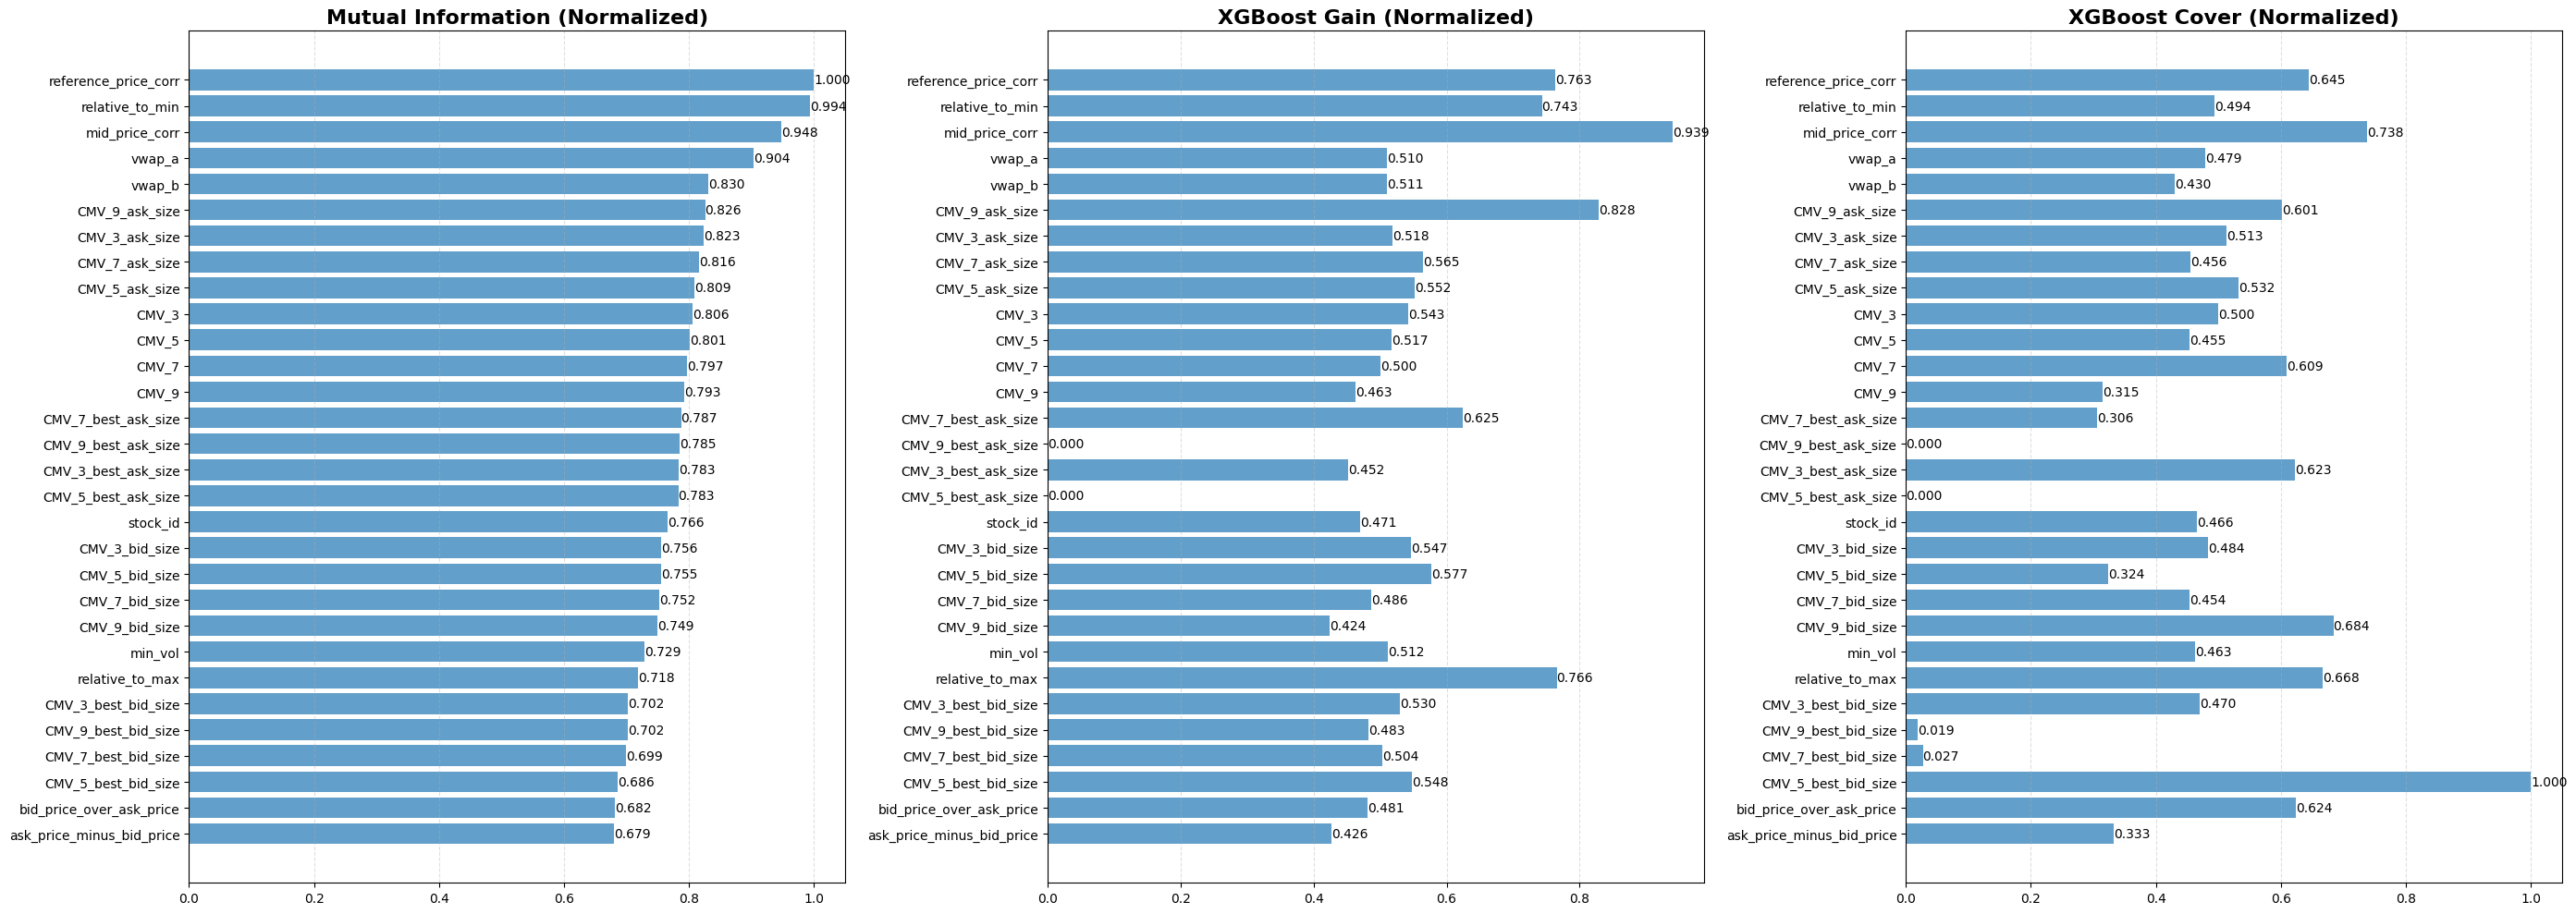

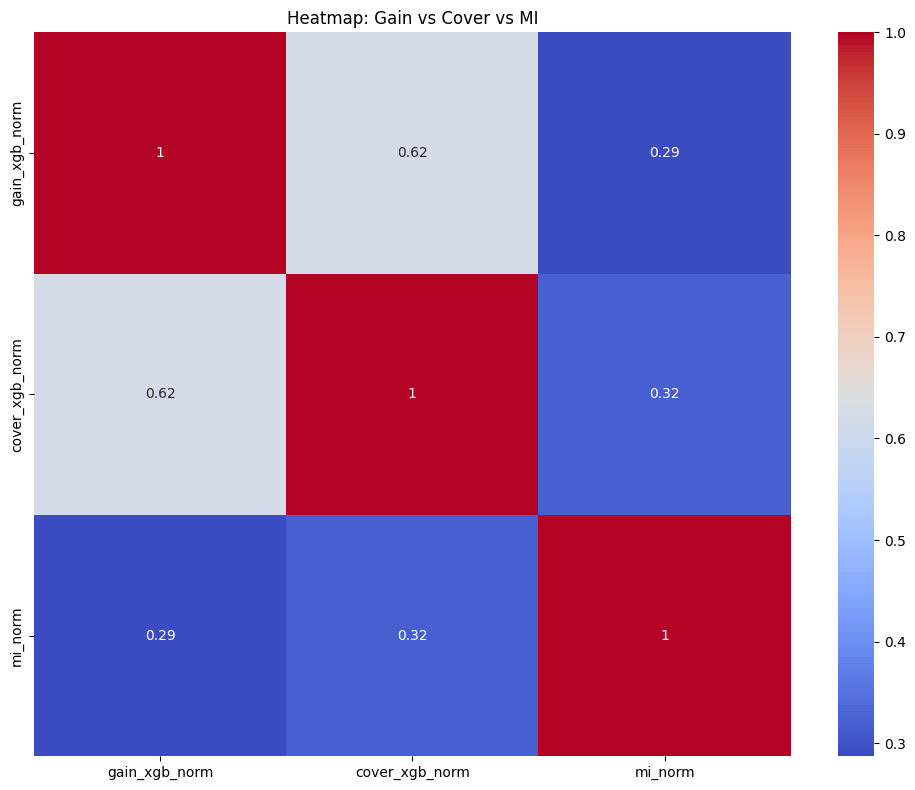

,gain_xgb,cover_xgb,gain_xgb_norm,cover_xgb_norm,rank_gain_xgb,rank_cover_xgb,mi,mi_norm,rank_mi
stock_id,6.918338,2316.604004,0.470615,0.466399,97,47,0.072139,0.766163,18
date_id,0.000000,0.000000,0.000000,0.000000,143,143,0.001336,0.014187,139
seconds_in_bucket,9.073700,1826.435669,0.617232,0.367714,14,90,0.032999,0.350477,65
imbalance_size,6.861610,1789.383911,0.466756,0.360254,99,93,0.034800,0.369598,62
imbalance_buy_sell_flag,6.746767,792.375000,0.458944,0.159528,106,138,0.000000,0.000000,144


In [64]:
importance_df = plot_xgb_importance_norm_3cols(
    X_train, y_train, top_n=30
)
importance_df.head()

**permutation**：置换重要性,就是把某个特征在验证集里“打乱顺序”，再看模型分数掉了多少；掉得越多，说明该特征对预测越重要。

## 原理
- 给定已训练好的模型 f 和验证集 (X_val, y_val)。
- 先算**基线分数**
 $$
 S_0 = \text{score}(y_{\text{val}}, f(X_{\text{val}}))
 $$
 （分数可用R^2,-MSE,-MAE）。
- 对第j个特征：把X_val的第j列随机打乱，重算分数  
  $$
  S_j = \text{score}(y_{\text{val}}, f(X_{\text{val}}^{(j)}))
  $$。
- 定义重要性  
$$
  I_j = S_0 - S_j
$$
  若用的是**损失**（MAE/MSE）做分数，就把式子换成  
$$
  I_j = \text{loss}\big(f(X_{\text{val}}^{(j)})\big) - \text{loss}\big(f(X_{\text{val}})\big)
$$
  ——损失涨多少就是重要性。
- 为了降低随机波动，**重复置换 \(R\) 次**，取均值/标准差：  
$$
\bar I_j=\frac{1}{R}\sum_{r=1}^R I_{j,r}
$$。

## permutation衡量的是
在**固定模型**下，特征 \(x_j\) 与目标 \(y\) 的 **条件关联（given 其它特征）** 对最终预测分数的贡献。直观地说：把这列破坏掉后，模型还能靠其他列“兜底”多少。


## 优势与局限
- **优势**：与模型无关、样本外衡量、可直接对接业务指标（IC、收益、MAE…）。
- **局限**：相关特征会**低估**单列重要性；计算量 ≈ 特征数 × 重复次数 × 一次推理成本。需要用成组置换/聚类来缓解。

In [ ]:
def run_permutation_rerank_analysis(
        X_train, 
        y_train,
        estimator,
        n_splits=5,
        n_repeats=1,
        random_state=42,
        top_n_features=20
    ):
    """
    将 permutation 重排的重要性计算、稳定性分析、所有可视化图表
    封装到一个函数里输出。
    
    返回:
        ranking_comparison : DataFrame
        stability_summary  : DataFrame
    """

    import numpy as np
    import pandas as pd
    import sklearn as sk
    import matplotlib.pyplot as plt
    from sklearn.inspection import permutation_importance

    # ----------------------------------------------
    # 1) K 折 permutation importance 计算
    # ----------------------------------------------
    feature_importance_permuation_list = []
    feature_importance_permuation_std_list = []
    splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train, y_train)

    for fold, (train_idx, val_idx) in enumerate(splitter):
        model = sk.base.clone(estimator)

        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold   = X_train.iloc[val_idx]
        y_val_fold   = y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)

        result = permutation_importance(
            model,
            X_val_fold,
            y_val_fold,
            scoring='neg_mean_absolute_error',
            n_repeats=n_repeats,
            random_state=random_state
        )

        imp_mean = pd.Series(result.importances_mean, index=X_train.columns)
        imp_std  = pd.Series(result.importances_std, index=X_train.columns)

        feature_importance_permuation_list.append(imp_mean)
        feature_importance_permuation_std_list.append(imp_std)

    # ----------------------------------------------
    # 2) 汇总重要性 & 稳定性指标
    # ----------------------------------------------
    permutation_importance_by_fold = pd.concat(feature_importance_permuation_list, axis=1)
    permutation_importance_by_fold.columns = [f'fold_{i}' for i in range(n_splits)]

    permutation_importance_std_by_fold = pd.concat(feature_importance_permuation_std_list, axis=1)
    permutation_importance_std_by_fold.columns = [f'fold_{i}_std' for i in range(n_splits)]

    permutation_importance_mean = permutation_importance_by_fold.mean(axis=1)
    permutation_importance_fold_std = permutation_importance_by_fold.std(axis=1)
    permutation_importance_fold_cv  = (
        permutation_importance_fold_std / (np.abs(permutation_importance_mean) + 1e-8)
    )

    stability_summary = pd.DataFrame({
        'permutation_importance_mean': permutation_importance_mean,
        'permutation_importance_fold_std': permutation_importance_fold_std,
        'permutation_importance_fold_cv': permutation_importance_fold_cv
    }).sort_values('permutation_importance_mean', ascending=False)

    # ----------------------------------------------
    # 3) 可视化图表打包输出
    # ----------------------------------------------

    # 图 1：稳定性散点图（CELL 36）
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 均值 vs 折间 std
    scatter1 = axes[0].scatter(
        permutation_importance_mean, permutation_importance_fold_std,
        alpha=0.6, s=50, c=permutation_importance_fold_cv, cmap='viridis'
    )
    axes[0].set_xlabel('Permutation Importance Mean')
    axes[0].set_ylabel('Fold-to-Fold Std')
    axes[0].set_title('Feature Importance Stability: Mean vs Fold Variance')
    plt.colorbar(scatter1, ax=axes[0]).set_label('CV')

    # 折内 std vs 折间 std
    scatter2 = axes[1].scatter(
        permutation_importance_std_by_fold.mean(axis=1),
        permutation_importance_fold_std,
        alpha=0.6, s=50, c=permutation_importance_mean, cmap='plasma'
    )
    axes[1].set_xlabel('Within-Fold Std')
    axes[1].set_ylabel('Fold-to-Fold Std')
    axes[1].set_title('Within-Fold vs Inter-Fold Variability')
    plt.colorbar(scatter2, ax=axes[1]).set_label('Importance Mean')

    plt.tight_layout()
    plt.show()

    # 图 2：不稳定特征 / 稳定特征（CELL 37）
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    unstable_features = stability_summary.nlargest(15, 'permutation_importance_fold_cv')
    axes[0].barh(unstable_features.index, unstable_features['permutation_importance_fold_cv'])
    axes[0].set_title("Top 15 Unstable Features (Highest CV)")
    axes[0].invert_yaxis()

    stable_features = stability_summary[
        stability_summary['permutation_importance_mean'].abs() > 1e-5
    ].nsmallest(15, 'permutation_importance_fold_cv')
    axes[1].barh(stable_features.index, stable_features['permutation_importance_fold_cv'])
    axes[1].set_title("Top 15 Most Stable Features (Lowest CV)")
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

    # 图 3：箱线图（CELL 38）
    selected_features = stability_summary.head(top_n_features).index

    fig, ax = plt.subplots(figsize=(12, 6))
    box_data = [permutation_importance_by_fold.loc[f].values for f in selected_features]
    ax.boxplot(box_data, labels=selected_features, patch_artist=True)
    ax.set_title(f'Top {top_n_features} Features — Fold Distribution Boxplot')
    ax.set_ylabel('Permutation Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------
    # 4) ranking_comparison （特征排序表）
    # ----------------------------------------------
    ranking_comparison = pd.DataFrame({
        'Feature': stability_summary.index,
        'Mean_Importance': stability_summary['permutation_importance_mean'],
        'CV': stability_summary['permutation_importance_fold_cv']
    })

    return ranking_comparison, stability_summary


In [ ]:
ranking_comparison, stability_summary = run_permutation_rerank_analysis(
    X_train,
    y_train,
    estimator=model,     # 你 Notebook 中的 LGBMRegressor
    n_splits=5,
    n_repeats=1
)


In [ ]:
import numpy as np
import pandas as pd
import time
import shap
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

import sklearn as sk
from sklearn.inspection import permutation_importance


class FeatureImportanceAnalyzer:
    """
    统一封装：
    1. LGBM 内置 SHAP + shap 包对比 (shap_compare)
    2. LGBM gain / split 特征重要性
    3. XGBoost gain / cover 特征重要性
    4. permutation 重排重要性 + 稳定性分析

    每个方法依旧返回各自的 DataFrame，额外提供 merge_importances 做联合对齐。
    """

    def __init__(self, X_train, y_train):
        # 统一处理 X_train 为 DataFrame，保存特征名
        if isinstance(X_train, pd.DataFrame):
            self.feature_names = X_train.columns.tolist()
            self.X_train = X_train.copy()
        else:
            self.feature_names = [f"f{i}" for i in range(X_train.shape[1])]
            self.X_train = pd.DataFrame(X_train, columns=self.feature_names)

        self.y_train = pd.Series(y_train).reset_index(drop=True)

        # 各种 DataFrame 结果存这里，方便后面 merge
        self.df_shap_lgb = None          # shap_compare 的结果
        self.df_lgb_gain_split = None    # LightGBM gain/split
        self.df_xgb_importance = None    # XGBoost gain/cover
        self.df_perm_ranking = None      # permutation ranking_comparison
        self.df_perm_stability = None    # permutation stability_summary
    

    # =====================================================================
    # 1. LGBM SHAP 对比 (保留原逻辑 & 返回 df_imp)
    # =====================================================================
    def shap_compare_lgb(self, model: LGBMRegressor, K: int = 50, sample_size: int = 100000):
        """
        等价于你原来的 shap_compare(model, X_train, K)，只是写成类方法。
        保留所有打印 & 图形；返回 df_imp，并缓存到 self.df_shap_lgb。
        """
        X_train = self.X_train
        feature_names = self.feature_names

        # ====================== 参数处理 ======================
        N = min(sample_size, len(X_train))
        X_sample = X_train.iloc[:N].copy()

        # ====================== 1. full SHAP (LightGBM 内置) ======================
        t0 = time.time()
        shap_full = model.predict(
            X_sample,
            pred_contrib=True,
            approximate=True,
            num_iteration=None
        )
        shap_full = shap_full[:, :-1]  # 去掉 bias
        t1 = time.time()

        # ====================== 2. K SHAP (LightGBM 内置) ======================
        t2 = time.time()
        shap_k = model.predict(
            X_sample,
            pred_contrib=True,
            approximate=True,
            num_iteration=K
        )
        shap_k = shap_k[:, :-1]
        t3 = time.time()

        # ====================== 3. SHAP 包 TreeExplainer ======================
        t4 = time.time()
        explainer = shap.TreeExplainer(model)
        shap_values_shap = explainer.shap_values(X_sample)
        t5 = time.time()

        if isinstance(shap_values_shap, list):  # 二分类
            shap_values_shap = shap_values_shap[1]

        # ====================== 4. 特征重要性对比 ======================
        imp_full = np.mean(np.abs(shap_full), axis=0)
        imp_k = np.mean(np.abs(shap_k), axis=0)
        imp_shap = np.mean(np.abs(shap_values_shap), axis=0)

        df_imp = pd.DataFrame({
            "feature": feature_names,
            "full_shap": imp_full,
            f"k{K}_shap": imp_k,
            "shap_package": imp_shap
        })
        df_imp["rank_full"] = df_imp["full_shap"].rank(ascending=False)
        df_imp[f"rank_k{K}"] = df_imp[f"k{K}_shap"].rank(ascending=False)
        df_imp["rank_shap"] = df_imp["shap_package"].rank(ascending=False)
        df_imp["rank_diff_k"] = df_imp["rank_full"] - df_imp[f"rank_k{K}"]
        df_imp["rank_diff_shap"] = df_imp["rank_full"] - df_imp["rank_shap"]
        df_imp = df_imp.sort_values("rank_full").reset_index(drop=True)

        # ====================== 打印速度结果 ======================
        print("======= 速度对比（秒） =======")
        print(f"1. Full SHAP (LightGBM内置): {t1 - t0:.3f} s")
        print(f"2. K={K} SHAP (LightGBM内置): {t3 - t2:.3f} s")
        print(f"3. SHAP包 TreeExplainer: {t5 - t4:.3f} s")
        print(f"加速倍率 (Full vs K={K}): {(t1 - t0)/(t3 - t2):.2f}x")
        print(f"加速倍率 (SHAP包 vs K={K}): {(t5 - t4)/(t3 - t2):.2f}x")

        # ====================== 前 20 特征 ======================
        print("\n======= 前 20 个特征的重要性对比 =======")
        try:
            from IPython.display import display
            display(df_imp.head(20))
        except Exception:
            print(df_imp.head(20))

        # ====================== 5. SHAP 相关性分析 ======================
        print("\n======= 方法间相关性 =======")
        correlation_matrix = df_imp[['full_shap', f'k{K}_shap', 'shap_package']].corr()
        print(correlation_matrix)

        # ====================== 6. 排名相关性 ======================
        spearman_full_k, _ = spearmanr(df_imp["rank_full"], df_imp[f"rank_k{K}"])
        spearman_full_shap, _ = spearmanr(df_imp["rank_full"], df_imp["rank_shap"])
        spearman_k_shap, _ = spearmanr(df_imp[f"rank_k{K}"], df_imp["rank_shap"])

        print("\n======= 排名一致性 (Spearman相关系数) =======")
        print(f"Full SHAP vs K={K} SHAP: {spearman_full_k:.4f}")
        print(f"Full SHAP vs SHAP包: {spearman_full_shap:.4f}")
        print(f"K={K} SHAP vs SHAP包: {spearman_k_shap:.4f}")

        # ====================== 7. 可视化对比 ======================
        top_features = df_imp.head(10)['feature'].values
        top_indices = [self.feature_names.index(f) for f in top_features]

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].barh(range(10), imp_full[top_indices])
        axes[0].set_title('Full SHAP (LightGBM)')
        axes[0].set_yticks(range(10))
        axes[0].set_yticklabels(top_features)

        axes[1].barh(range(10), imp_k[top_indices])
        axes[1].set_title(f'K={K} SHAP (LightGBM)')
        axes[1].set_yticks(range(10))
        axes[1].set_yticklabels(top_features)

        axes[2].barh(range(10), imp_shap[top_indices])
        axes[2].set_title('SHAP Package')
        axes[2].set_yticks(range(10))
        axes[2].set_yticklabels(top_features)

        plt.tight_layout()
        plt.show()

        # 缓存 & 返回
        self.df_shap_lgb = df_imp.copy()
        return df_imp

    # =====================================================================
    # 2. LightGBM gain / split 重要性
    def plot_lgbm_gain_split_importance(self, top_n=20, lgb_params=None):
        """
        训练一个 LGBMRegressor，画图并返回 merged_importance（index=feature）。
        """

        X_train = self.X_train
        y_train = self.y_train
        feature_names = self.feature_names

        # ---------------------------
        # 默认 LGB 参数
        # ---------------------------
        import warnings
        warnings.filterwarnings("ignore")
        if lgb_params is None:
            lgb_params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'verbosity': -1,    # 静音模式
    'random_state': 42,

    # 学习率与迭代
    'learning_rate': 0.05,
    'n_estimators': 2000,

    # 树结构
    'num_leaves': 63,
    'max_depth': 10,

    # 正则化
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,

    # 采样（!!! 关键修复 warning !!!）
    'feature_fraction': 0.8,     # = colsample_bytree
    'colsample_bytree': 0.8,     # 明确写以避免 warning
    'bagging_fraction': 0.8,     # = subsample
    'subsample': 0.8,            # 明确写
    'bagging_freq': 5,
    'subsample_freq': 5,         # 明确写

    # 其他
    'max_bin': 255,
    'num_threads': -1,
    'force_col_wise': True
}

        # 训练
        model = lgb.LGBMRegressor(**lgb_params)
        model.fit(X_train, y_train)

        booster = model.booster_
        gain = booster.feature_importance(importance_type='gain')
        split = booster.feature_importance(importance_type='split')

        # -----------------------------------------------------------------
        # 合并结果
        # -----------------------------------------------------------------
        merged_importance = pd.DataFrame({
            'feature': feature_names,
            'gain_lgb': gain,
            'split_lgb': split
        }).set_index('feature')

        # 归一化
        merged_importance['gain_lgb_norm'] = (
            merged_importance['gain_lgb'] /
            merged_importance['gain_lgb'].max()
        )
        merged_importance['split_lgb_norm'] = (
            merged_importance['split_lgb'] /
            merged_importance['split_lgb'].max()
        )

        merged_importance['gain_lgb_rank'] = merged_importance['gain_lgb'].rank(ascending=False)
        merged_importance['split_lgb_rank'] = merged_importance['split_lgb'].rank(ascending=False)

        # 相关性
        rank_corr = merged_importance['gain_lgb_rank'].corr(
            merged_importance['split_lgb_rank'], method='spearman'
        )

        print('\n--- LGBM 特征重要性分析 ---\n')
        print(f"Spearman Rank Correlation (Gain vs Split): {rank_corr:.4f}")

        # Top5 对比
        print("\n--- Top 5 Features by Gain vs Split ---\n")
        top_5_gain = merged_importance.sort_values('gain_lgb', ascending=False).index[:5].tolist()
        top_5_split = merged_importance.sort_values('split_lgb', ascending=False).index[:5].tolist()
        print(f"Top 5 Features (Gain): {top_5_gain}")
        print(f"Top 5 Features (Split): {top_5_split}")

        unique_to_gain = set(top_5_gain) - set(top_5_split)
        unique_to_split = set(top_5_split) - set(top_5_gain)

        if unique_to_gain or unique_to_split:
            print("\n差异分析：")
            print(f" 仅在 Gain Top 5 中出现: {unique_to_gain or '无'}")
            print(f" 仅在 Split Top 5 中出现: {unique_to_split or '无'}")
        else:
            print("\n差异分析：Top 5 完全一致。")

        # -----------------------------------------------------------------
        # 绘图（取 gain top_n）
        # -----------------------------------------------------------------
        top_features = merged_importance.sort_values('gain_lgb', ascending=False).head(top_n)

        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='gain_lgb_norm', y=top_features.index,
            data=top_features, label='Gain (Normalized)', alpha=0.8
        )
        sns.barplot(
            x='split_lgb_norm', y=top_features.index,
            data=top_features, label='Split (Normalized)', alpha=0.6
        )

        plt.title(f'LightGBM Top {top_n} Feature Importance (Gain vs Split, Normalized)', fontsize=16)
        plt.xlabel('Normalized Importance')
        plt.ylabel('Features')
        plt.legend()
        plt.grid(axis='x', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # 暴露到类里
        self.df_lgb_gain_split = merged_importance.copy()

        return merged_importance



# =====================================================================
    # 3. XGBoost gain / cover 重要性
    # =====================================================================
    from sklearn.feature_selection import mutual_info_regression

    def plot_xgb_importance_norm(self, top_n=30, xgb_params=None):
        """
        增强版：
        - XGBoost Gain / Cover
        - Mutual Information (MI)
        - 输出带 MI 的 importance df
        - 绘制 MI + XGB gain 对比图
        - 绘制特征相关系数热力图
        """
        from sklearn.feature_selection import mutual_info_regression
        X_train = self.X_train
        y_train = self.y_train
        feature_names = self.feature_names
        # ---------------------------
        # XGB 默认参数
        # ---------------------------
        if xgb_params is None:
            xgb_params = dict(
                n_estimators=2000,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=0.5,
                reg_lambda=5.0,
                min_child_weight=5,
                gamma=0.2,
                random_state=42,
                objective='reg:absoluteerror',
                eval_metric='mae',
                tree_method='hist',
                grow_policy='lossguide'
            )

        # ---------------------------
        # 训练 XGBoost
        # ---------------------------
        model = XGBRegressor(**xgb_params)
        model.fit(X_train, y_train)

        booster = model.get_booster()

        imp_gain_dict = booster.get_score(importance_type='gain')
        imp_cover_dict = booster.get_score(importance_type='cover')

        # ---------------------------
        # f0,f1,f2 → feature 映射
        # ---------------------------
        def map_features(imp_dict):
            keys = list(imp_dict.keys())
            if keys and all(k.startswith('f') and k[1:].isdigit() for k in keys):
                new_dict = {}
                for k, v in imp_dict.items():
                    idx = int(k[1:])
                    new_dict[feature_names[idx]] = v
                return new_dict
            return imp_dict.copy()

        imp_gain_dict = map_features(imp_gain_dict)
        imp_cover_dict = map_features(imp_cover_dict)

        # ---------------------------
        # 合并 DataFrame
        # ---------------------------
        df = pd.DataFrame(index=feature_names)   # 使用全部特征，不只用 XGB importance

        df['gain_xgb'] = pd.Series(imp_gain_dict)
        df['cover_xgb'] = pd.Series(imp_cover_dict)

        df = df.fillna(0)

        # 归一化
        for col in ['gain_xgb', 'cover_xgb']:
            max_val = df[col].max()
            df[col + '_norm'] = df[col] / max_val if max_val > 0 else 0

        # 排名
        df['rank_gain_xgb'] = df['gain_xgb_norm'].rank(ascending=False, method='dense').astype(int)
        df['rank_cover_xgb'] = df['cover_xgb_norm'].rank(ascending=False, method='dense').astype(int)

        # ==========================================================
        # 🔥 新增：Mutual Information (MI)
        # ==========================================================
        X_np = pd.DataFrame(X_train, columns=feature_names).copy()

        # 数值型变量：用中位数填补
        for col in X_np.columns:
            if X_np[col].isna().any():
                X_np[col] = X_np[col].fillna(X_np[col].median())

        # y 的 NaN 也填补
        y_np = pd.Series(y_train)
        if y_np.isna().any():
            y_np = y_np.fillna(y_np.median())
        mi = mutual_info_regression(X_np.values, y_np.values, random_state=42)

        df['mi'] = mi
        df['mi_norm'] = df['mi'] / df['mi'].max()
        df['rank_mi'] = df['mi_norm'].rank(ascending=False, method='dense').astype(int)
        # ==========================================================
        # 🔥 新增：特征相关性 (Pearson)



        # ---------------------------
        # 存入类中
        # ---------------------------
        self.df_xgb_importance = df.copy()

        # ==========================================================
        # 绘图：MI 与 XGB gain 对比
        # ==========================================================
        plot_df = df.sort_values('mi_norm', ascending=False).head(top_n)
        fig, axes = plt.subplots(1, 3, figsize=(28, 10))

        # -------------------------
        # 子图 1：MI
        # -------------------------
        ax = axes[0]
        ax.barh(plot_df.index, plot_df['mi_norm'], alpha=0.7)
        ax.set_title("Mutual Information (Normalized)", fontsize=16, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', linestyle='--', alpha=0.4)
        for i, v in enumerate(plot_df['mi_norm']):
            ax.text(v, i, f"{v:.3f}", va='center', ha='left', fontsize=10)

        # -------------------------
        # 子图 2：XGBoost Gain
        # -------------------------
        ax = axes[1]
        ax.barh(plot_df.index, plot_df['gain_xgb_norm'], alpha=0.7)
        ax.set_title("XGBoost Gain (Normalized)", fontsize=16, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', linestyle='--', alpha=0.4)
        for i, v in enumerate(plot_df['gain_xgb_norm']):
            ax.text(v, i, f"{v:.3f}", va='center', ha='left', fontsize=10)

        # -------------------------
        # 子图 3：XGBoost Cover
        # -------------------------
        ax = axes[2]
        ax.barh(plot_df.index, plot_df['cover_xgb_norm'], alpha=0.7)
        ax.set_title("XGBoost Cover (Normalized)", fontsize=16, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', linestyle='--', alpha=0.4)
        for i, v in enumerate(plot_df['cover_xgb_norm']):
            ax.text(v, i, f"{v:.3f}", va='center', ha='left', fontsize=10)

        plt.tight_layout()
        plt.show()

        # ==========================================================
        # 绘制特征相关系数热力图
        # ==========================================================
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[['cover_xgb_norm','gain_xgb_norm', 'mi_norm']].corr(), cmap='coolwarm', annot=True)
        plt.title("Heatmap: Corr vs MI vs Gain")
        plt.tight_layout()
        plt.show()

        return df


    # =====================================================================
    # 4. permutation 重排重要性 + 稳定性分析
    # =====================================================================
    def run_permutation_rerank_analysis(
        self,
        estimator,
        n_splits=5,
        n_repeats=1,
        random_state=42,
        top_n_features=20
    ):
        """
        与你原来的 run_permutation_rerank_analysis 等价。
        返回 ranking_comparison, stability_summary。
        """
        X_train = self.X_train
        y_train = self.y_train

        feature_importance_permuation_list = []
        feature_importance_permuation_std_list = []

        splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train, y_train)

        for fold, (train_idx, val_idx) in enumerate(splitter):
            model = sk.base.clone(estimator)

            X_train_fold = X_train.iloc[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]

            model.fit(X_train_fold, y_train_fold)

            result = permutation_importance(
                model,
                X_val_fold,
                y_val_fold,
                scoring='neg_mean_absolute_error',
                n_repeats=n_repeats,
                random_state=random_state
            )

            imp_mean = pd.Series(result.importances_mean, index=X_train.columns)
            imp_std = pd.Series(result.importances_std, index=X_train.columns)

            feature_importance_permuation_list.append(imp_mean)
            feature_importance_permuation_std_list.append(imp_std)

        permutation_importance_by_fold = pd.concat(feature_importance_permuation_list, axis=1)
        permutation_importance_by_fold.columns = [f'fold_{i}' for i in range(n_splits)]

        permutation_importance_std_by_fold = pd.concat(feature_importance_permuation_std_list, axis=1)
        permutation_importance_std_by_fold.columns = [f'fold_{i}_std' for i in range(n_splits)]

        permutation_importance_mean = permutation_importance_by_fold.mean(axis=1)
        permutation_importance_fold_std = permutation_importance_by_fold.std(axis=1)

        permutation_importance_fold_cv = (
            permutation_importance_fold_std / (np.abs(permutation_importance_mean) + 1e-8)
        )

        stability_summary = pd.DataFrame({
            'permutation_importance_mean': permutation_importance_mean,
            'permutation_importance_fold_std': permutation_importance_fold_std,
            'permutation_importance_fold_cv': permutation_importance_fold_cv
        }).sort_values('permutation_importance_mean', ascending=False)

        # -------- 图 1：稳定性散点图 --------
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        scatter1 = axes[0].scatter(
            permutation_importance_mean,
            permutation_importance_fold_std,
            alpha=0.6, s=50,
            c=permutation_importance_fold_cv, cmap='viridis'
        )
        axes[0].set_xlabel('Permutation Importance Mean')
        axes[0].set_ylabel('Fold-to-Fold Std')
        axes[0].set_title('Feature Importance Stability: Mean vs Fold Variance')
        plt.colorbar(scatter1, ax=axes[0]).set_label('CV')

        scatter2 = axes[1].scatter(
            permutation_importance_std_by_fold.mean(axis=1),
            permutation_importance_fold_std,
            alpha=0.6, s=50,
            c=permutation_importance_mean, cmap='plasma'
        )
        axes[1].set_xlabel('Within-Fold Std')
        axes[1].set_ylabel('Fold-to-Fold Std')
        axes[1].set_title('Within-Fold vs Inter-Fold Variability')
        plt.colorbar(scatter2, ax=axes[1]).set_label('Importance Mean')

        plt.tight_layout()
        plt.show()

        # -------- 图 2：不稳定 / 稳定 特征 --------
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        unstable_features = stability_summary.nlargest(15, 'permutation_importance_fold_cv')
        axes[0].barh(unstable_features.index, unstable_features['permutation_importance_fold_cv'])
        axes[0].set_title("Top 15 Unstable Features (Highest CV)")
        axes[0].invert_yaxis()

        stable_features = stability_summary[
            stability_summary['permutation_importance_mean'].abs() > 1e-5
        ].nsmallest(15, 'permutation_importance_fold_cv')
        axes[1].barh(stable_features.index, stable_features['permutation_importance_fold_cv'])
        axes[1].set_title("Top 15 Most Stable Features (Lowest CV)")
        axes[1].invert_yaxis()

        plt.tight_layout()
        plt.show()

        # -------- 图 3：箱线图 --------
        selected_features = stability_summary.head(top_n_features).index
        fig, ax = plt.subplots(figsize=(12, 6))
        box_data = [permutation_importance_by_fold.loc[f].values for f in selected_features]
        ax.boxplot(box_data, labels=selected_features, patch_artist=True)
        ax.set_title(f'Top {top_n_features} Features — Fold Distribution Boxplot')
        ax.set_ylabel('Permutation Importance')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        ranking_comparison = pd.DataFrame({
            'feature': stability_summary.index,
            'perm_mean': stability_summary['permutation_importance_mean'],
            'perm_cv': stability_summary['permutation_importance_fold_cv']
        }).set_index('feature')

        # 缓存
        self.df_perm_ranking = ranking_comparison.copy()
        self.df_perm_stability = stability_summary.copy()

        return ranking_comparison, stability_summary

    # =====================================================================
    # 5. 合并四种重要性 DataFrame
    # =====================================================================

    def merge_importances(self):
        """
        将已经计算好的 shap / lgb / xgb / permutation 的 DataFrame 合并在一起。
        feature 为 index。没算到的部分就留 NaN。
        """
        base_index = pd.Index(self.feature_names, name='feature')
        merged = pd.DataFrame(index=base_index)

        # 1) shap_compare_lgb 结果
        if self.df_shap_lgb is not None:
            df = self.df_shap_lgb.set_index('feature')
            merged = merged.join(df, how='left')

        # 2) LGB gain/split
        if self.df_lgb_gain_split is not None:
            merged = merged.join(self.df_lgb_gain_split, how='left')

        # 3) XGB gain/cover
        if self.df_xgb_importance is not None:
            merged = merged.join(self.df_xgb_importance, how='left')

        # 4) permutation ranking/stability
        if self.df_perm_ranking is not None:
            merged = merged.join(self.df_perm_ranking, how='left')
        if self.df_perm_stability is not None:
            # 避免列名冲突，加前缀
            perm_cols = {
                'permutation_importance_mean': 'perm_mean_full',
                'permutation_importance_fold_std': 'perm_fold_std',
                'permutation_importance_fold_cv': 'perm_fold_cv_full'
            }
            df_perm_stab = self.df_perm_stability.rename(columns=perm_cols)
            merged = merged.join(df_perm_stab, how='left')

        return merged


In [ ]:

analyzer = FeatureImportanceAnalyzer(X_train, y_train)
df_shap = analyzer.shap_compare_lgb(model, K=50)
df_lgb = analyzer.plot_lgbm_gain_split_importance(top_n=20)
df_xgb = analyzer.plot_xgb_importance_norm(top_n=30)
df_perm_rank, df_perm_stab = analyzer.run_permutation_rerank_analysis(
    estimator=model,
    n_splits=5,
    n_repeats=1,
    top_n_features=20
)
df_all = analyzer.merge_importances()

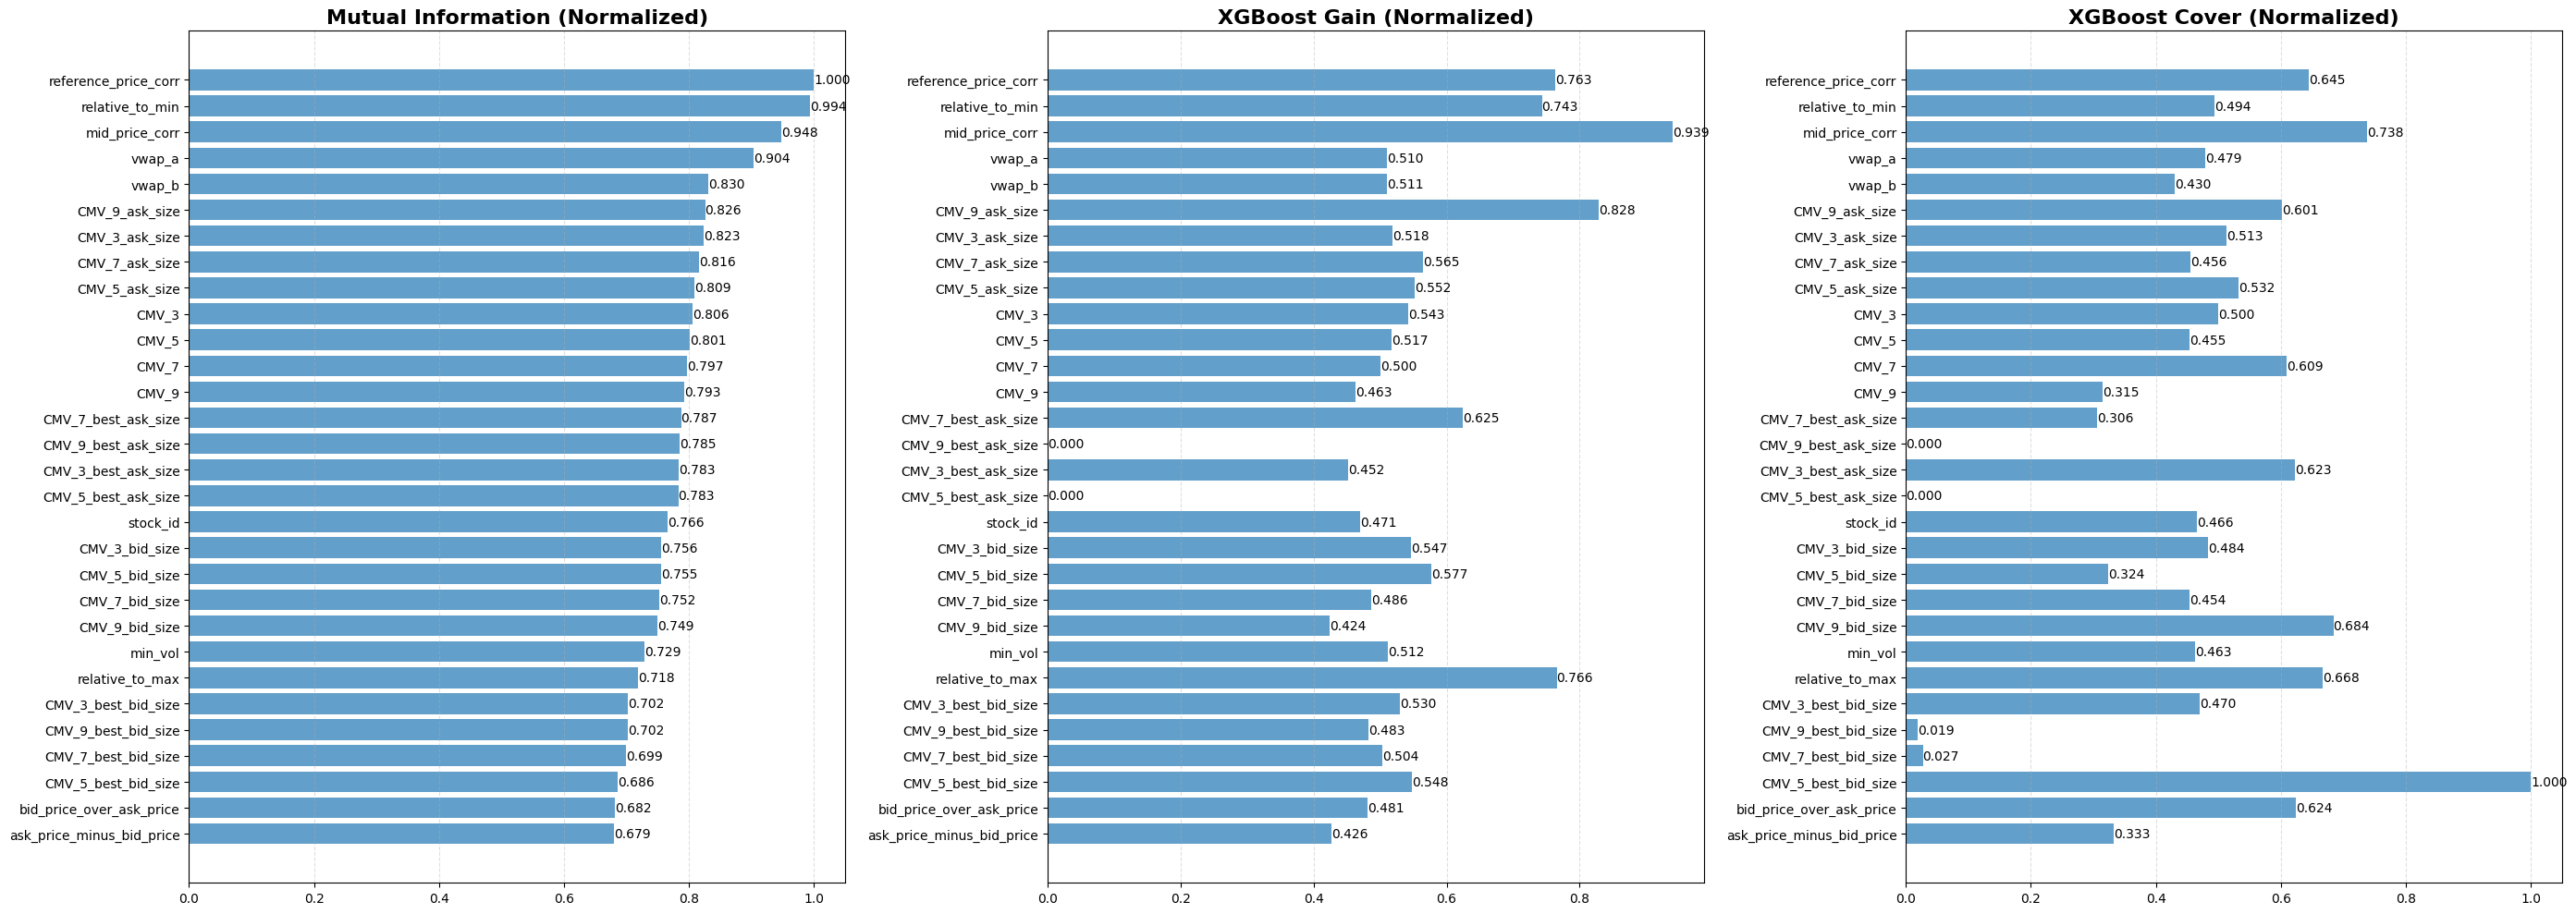

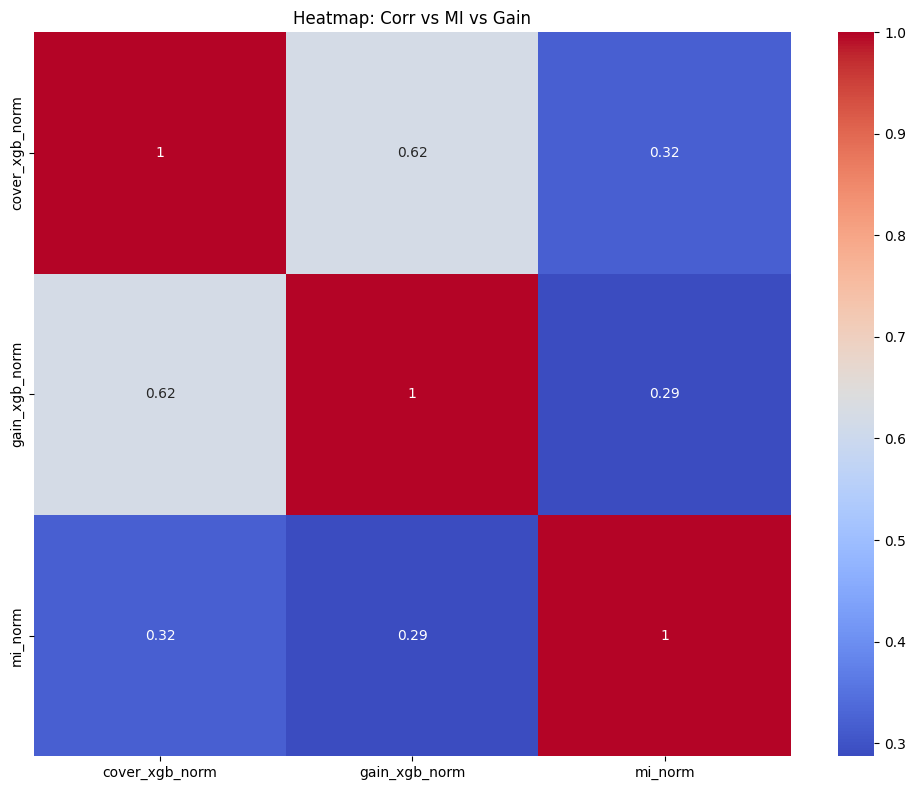

In [62]:
import warnings
warnings.filterwarnings("ignore")
analyzer = FeatureImportanceAnalyzer(X_train, y_train)
#df_lgb = analyzer.plot_lgbm_gain_split_importance(top_n=20)
df_xgb = analyzer.plot_xgb_importance_norm(top_n=30)


In [ ]:
def composite_feature_selection(df_all, top_k=10):
    importance_columns = ['k50_shap', 'gain_lgb', 'split_lgb', 'gain_xgb', 'cover_xgb', 'perm_mean']
    missing_cols = [col for col in importance_columns if col not in df_all.columns]
    if missing_cols:
        raise ValueError(f"缺少以下重要性指标列: {missing_cols}")
    combined_df = df_all[importance_columns].copy()
    # 数据归一化 (min-max归一化)
    normalized_df = combined_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    # 计算综合得分 - 等权重
    # 如果需要自定义权重，可以修改这里
    weights = {
        'k50_shap': 1.0,
        'gain_lgb': 1.0, 
        'split_lgb': 1.0,
        'gain_xgb': 1.0,
        'cover_xgb': 1.0,
        'perm_mean': 1.0
    }
    
    # 应用权重并计算加权平均
    weighted_scores = pd.DataFrame()
    for col in normalized_df.columns:
        weighted_scores[col] = normalized_df[col] * weights.get(col, 1.0)
    
    # 计算综合得分
    combined_df['composite_score'] = weighted_scores.mean(axis=1)
    # 计算最终排名
    combined_df['final_rank'] = combined_df['composite_score'].rank(ascending=False)
    # 如果原始数据框有特征名称列，可以添加进来
    if 'feature_name' in df_all.columns:
        combined_df['feature_name'] = df_all['feature_name']
    elif df_all.index.name is not None:
        combined_df['feature_name'] = df_all.index
    else:
        combined_df['feature_name'] = [f'feature_{i}' for i in range(len(df_all))]
    # 排序并返回top_k
    final_ranking = combined_df.sort_values('composite_score', ascending=False)
    print(f"综合特征选择完成，前{top_k}个特征已确定")
    return final_ranking


In [ ]:
results=composite_feature_selection(df_all)

In [ ]:
from matplotlib_venn import venn2, venn3
plt.style.use('seaborn-v0_8')
def plot_method_comparison(results, top_k=20):
    """比较不同方法的前N个重要特征"""
    fig, axes = plt.subplots(2,4, figsize=(20, 12))
    axes = axes.ravel()
    
    methods = {
        'LightGBM Gain': results['gain_lgb'],
        'LightGBM Split': results['split_lgb'],
        'XGBoost Gain': results['gain_xgb'],
        'XGBoost Cover': results['cover_xgb'],
        'Permutation (LGB)': results['perm_mean'],
        'SHAP (LGB)': results['k50_shap'],
        'Composite Score': results['composite_score']
    }
    
    for idx, (method_name, importance) in enumerate(methods.items()):
        top_features_data = importance.nlargest(top_k)
        
        axes[idx].barh(range(len(top_features_data)), top_features_data.values)
        axes[idx].set_yticks(range(len(top_features_data)))
        axes[idx].set_yticklabels(top_features_data.index, fontsize=8)
        axes[idx].set_title(f'{method_name} - Top {top_k}')
        axes[idx].set_xlabel('Importance Score')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_method_comparison(results, top_k=20)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

def plot_comprehensive_feature_analysis(results, top_k=20, max_trend_k=100):
    """
    综合特征分析：包含方法比较、排名相关性、特征重叠和趋势分析
    
    参数:
    results: 包含各种重要性指标的结果字典
    top_features: 包含综合得分的DataFrame
    top_k: 显示前N个重要特征
    max_trend_k: 趋势分析的最大top_k值
    """
    plt.style.use('seaborn-v0_8')
    
    # 定义方法映射（保持您指定的结构）
    methods = {
        'LightGBM Gain': results['gain_lgb'],
        'LightGBM Split': results['split_lgb'],
        'XGBoost Gain': results['gain_xgb'],
        'XGBoost Cover': results['cover_xgb'],
        'Permutation (LGB)': results['perm_mean'],
        'SHAP (LGB)': results['k50_shap'],
        'Composite Score': results['composite_score']
    }
    
    # 创建综合图形
    fig = plt.figure(figsize=(25, 20))
    
    # 1. 方法比较条形图 (2x4布局中的前6个)
    for idx, (method_name, importance) in enumerate(methods.items()):
        if idx < 6:  # 前6个方法
            ax = plt.subplot(4, 4, idx + 1)
            top_features_data = importance.nlargest(top_k)
            
            ax.barh(range(len(top_features_data)), top_features_data.values, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(top_features_data))))
            ax.set_yticks(range(len(top_features_data)))
            ax.set_yticklabels(top_features_data.index, fontsize=8)
            ax.set_title(f'{method_name} - Top {top_k}', fontsize=10, fontweight='bold')
            ax.set_xlabel('Importance Score', fontsize=9)
            ax.grid(True, alpha=0.3)
    
    # 2. 排名相关性热图
    ax_corr = plt.subplot(4, 4, 7)
    methods_data = {
        'LGB_Gain': results['gain_lgb'],
        'LGB_Split': results['split_lgb'],
        'XGB_Gain': results['gain_xgb'],
        'XGB_Cover': results['cover_xgb'],
        'Perm_LGB': results['perm_mean'],
        'SHAP_LGB': results['k50_shap']
    }
    
    rank_df = pd.DataFrame()
    for method_name, importance in methods_data.items():
        rank_df[method_name] = importance.rank(ascending=False)
    
    correlation_matrix = rank_df.corr(method='spearman')
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
               center=0, fmt='.2f', square=True, ax=ax_corr,
               cbar_kws={'shrink': 0.8})
    ax_corr.set_title('Rank Correlation (Spearman)', fontsize=10, fontweight='bold')
    
    # 3. 特征重叠热图
    ax_overlap = plt.subplot(4, 4, 8)
    overlap_methods = {
        'LGB_Gain': results['gain_lgb'].nlargest(top_k).index,
        'LGB_Split': results['split_lgb'].nlargest(top_k).index,
        'XGB_Gain': results['gain_xgb'].nlargest(top_k).index,
        'Permutation': results['perm_mean'].nlargest(top_k).index,
        'SHAP': results['k50_shap'].nlargest(top_k).index
    }
    
    overlap_matrix = pd.DataFrame(index=overlap_methods.keys(), 
                                 columns=overlap_methods.keys())
    
    for method1, features1 in overlap_methods.items():
        for method2, features2 in overlap_methods.items():
            overlap = len(set(features1) & set(features2)) / top_k
            overlap_matrix.loc[method1, method2] = overlap
    
    sns.heatmap(overlap_matrix.astype(float), annot=True, fmt='.2f', cmap='YlOrRd', 
               ax=ax_overlap, cbar_kws={'label': 'Overlap Ratio'})
    ax_overlap.set_title(f'Feature Overlap (Top {top_k})', fontsize=10, fontweight='bold')
    
    # 4. 韦恩图 (使用三种核心方法)
    ax_venn = plt.subplot(4, 4, 11)
    lgb_top = set(results['gain_lgb'].nlargest(top_k).index)
    perm_top = set(results['perm_mean'].nlargest(top_k).index)
    shap_top = set(results['k50_shap'].nlargest(top_k).index)
    
    try:
        venn_diagram = venn3([lgb_top, perm_top, shap_top], 
                            ('LightGBM Gain', 'Permutation', 'SHAP'), ax=ax_venn)
        ax_venn.set_title(f'Core Feature Intersection (Top {top_k})', 
                         fontsize=10, fontweight='bold')
        
        # 设置韦恩图颜色
        for patch in venn_diagram.patches:
            patch.set_alpha(0.7)
    except Exception as e:
        ax_venn.text(0.5, 0.5, f'Venn diagram error:\n{str(e)}', 
                    ha='center', va='center', transform=ax_venn.transAxes, fontsize=8)
    
    # 5. 共同特征趋势分析
    ax_trend = plt.subplot(4, 4, 12)
    common_counts = []
    
    for k in range(1, max_trend_k + 1):
        lgb_set = set(results['gain_lgb'].nlargest(k).index)
        perm_set = set(results['perm_mean'].nlargest(k).index)
        shap_set = set(results['k50_shap'].nlargest(k).index)
        common = lgb_set & perm_set & shap_set
        common_counts.append(len(common))
    
    plt.plot(range(1, max_trend_k + 1), common_counts, 
             marker='o', markersize=2, linewidth=1.5, color='b', alpha=0.7)
    plt.axhline(y=max(common_counts), color='r', linestyle='--', alpha=0.7, 
                label=f'Max: {max(common_counts)}')
    plt.xlabel('Top K Features')
    plt.ylabel('Common Features')
    plt.title('Common Features Trend', fontsize=10, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    
    # 6. 综合得分分布
    ax_dist = plt.subplot(4, 4, 16)
    
    composite_scores = results['composite_score']
    ax_dist.hist(composite_scores, bins=30, alpha=0.7, color='lightblue', 
                    edgecolor='black')
    ax_dist.axvline(composite_scores.nlargest(top_k).min(), color='red', 
                       linestyle='--', linewidth=2, label=f'Top {top_k} cutoff')
    ax_dist.set_xlabel('Composite Score')
    ax_dist.set_ylabel('Frequency')
    ax_dist.set_title('Composite Score Distribution', fontsize=10, fontweight='bold')
    ax_dist.legend(fontsize=8)
    ax_dist.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    common_features = lgb_top & perm_top & shap_top
    print(f"=== 特征分析统计 (Top {top_k}) ===")
    print(f"三种方法共同特征数量: {len(common_features)}")
    print(f"共同特征: {list(common_features)}")
    print(f"趋势分析最大共同特征数: {max(common_counts)} (在top_k={np.argmax(common_counts) + 1}时)")
    
    return {
        'correlation_matrix': correlation_matrix,
        'overlap_matrix': overlap_matrix,
        'common_features': common_features,
        'trend_results': {
            'top_k_values': range(1, max_trend_k + 1),
            'common_counts': common_counts,
            'max_count': max(common_counts),
            'max_k': np.argmax(common_counts) + 1
        }
    }

# 单独的函数版本（如果需要单独调用）
def plot_common_features_trend(results, max_top_k=100):
    """随着top_k从1到max_top_k变化时，三种方法共同重合特征数量"""
    common_counts = []
    
    for top_k in range(1, max_top_k + 1):
        lgb_top = set(results['gain_lgb'].nlargest(top_k).index)
        perm_top = set(results['perm_mean'].nlargest(top_k).index)
        shap_top = set(results['k50_shap'].nlargest(top_k).index)
        common = lgb_top & perm_top & shap_top
        common_counts.append(len(common))
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_top_k + 1), common_counts, 
             marker='o', markersize=4, linewidth=2, color='b')
    plt.title('Number of Common Features Across Three Methods vs Top K', fontsize=14)
    plt.xlabel('Top K Features', fontsize=12)
    plt.ylabel('Number of Common Features', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=max(common_counts), color='r', linestyle='--', alpha=0.7, 
                label=f'Max: {max(common_counts)}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'top_k_values': range(1, max_top_k + 1),
        'common_counts': common_counts,
        'max_count': max(common_counts),
        'max_k': np.argmax(common_counts) + 1
    }



In [ ]:
plot_comprehensive_feature_analysis(results, top_k=20, max_trend_k=100)

In [ ]:
def analyze_feature_correlation(top_features, X_train, correlation_threshold=0.7):
    
    feature_names = top_features.index.tolist()
    X_top = X_train[feature_names]
    correlation_matrix = X_top.corr()
    
    # 创建特征排名字典（排名越靠前，数字越小）
    feature_ranks = {feature: i for i, feature in enumerate(feature_names)}
    
    # 找出高相关特征对
    high_corr_pairs = []
    features_to_remove = set()
    
    # 遍历上三角矩阵
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = abs(correlation_matrix.iloc[i, j])
            if corr_value > correlation_threshold:
                feature_i = correlation_matrix.columns[i]
                feature_j = correlation_matrix.columns[j]
                
                # 保留排名靠前的特征，删除排名靠后的
                if feature_ranks[feature_i] < feature_ranks[feature_j]:
                    features_to_remove.add(feature_j)
                else:
                    features_to_remove.add(feature_i)
                
                high_corr_pairs.append({
                    'feature1': feature_i,
                    'feature2': feature_j,
                    'correlation': corr_value,
                    'rank1': feature_ranks[feature_i],
                    'rank2': feature_ranks[feature_j],
                    'removed': feature_j if feature_ranks[feature_i] < feature_ranks[feature_j] else feature_i
                })
    
    # 筛选后的特征
    selected_features = [f for f in feature_names if f not in features_to_remove]
    
    print(f"原始特征数量: {len(feature_names)}")
    print(f"删除的高相关特征数量: {len(features_to_remove)}")
    print(f"筛选后特征数量: {len(selected_features)}")
    
    # 显示高相关特征对
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
        print("\n前10对高相关特征:")
        print(high_corr_df.head(10)[['feature1', 'feature2', 'correlation', 'removed']])
    
    return selected_features, correlation_matrix, high_corr_df

def plot_correlation_analysis(correlation_matrix, selected_features, top_features, high_corr_df):
    """
    绘制相关性分析相关的可视化
    """

    plt.figure(figsize=(20, 16))
    
    # 选择前50个特征绘制热图
    top_50_features = top_features.head(50).index
    corr_top_50 = correlation_matrix.loc[top_50_features, top_50_features]
    
    mask = np.triu(np.ones_like(corr_top_50, dtype=bool))
    sns.heatmap(corr_top_50, mask=mask, cmap='RdBu_r', center=0, 
                square=True, annot=False, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix (Top 50 Features)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # 2. 相关性分布直方图
    plt.figure(figsize=(12, 5))
    
    # 提取上三角矩阵的值（不包括对角线）
    corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
    corr_values_abs = np.abs(corr_values)
    
    plt.subplot(1, 2, 1)
    plt.hist(corr_values, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    plt.axvline(x=0.7, color='red', linestyle='--', label=f'Threshold (0.7)')
    plt.axvline(x=-0.7, color='red', linestyle='--')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Correlations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(corr_values_abs, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
    plt.axvline(x=0.7, color='red', linestyle='--', label=f'Threshold (0.7)')
    plt.xlabel('Absolute Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Absolute Feature Correlations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. 高相关特征对的可视化
    if not high_corr_df.empty:
        plt.figure(figsize=(12, 8))
        top_high_corr = high_corr_df.head(20).copy()
        
        # 创建条形图
        y_pos = np.arange(len(top_high_corr))
        plt.barh(y_pos, top_high_corr['correlation'], color='salmon', alpha=0.7)
        
        # 标注被删除的特征
        for i, (idx, row) in enumerate(top_high_corr.iterrows()):
            plt.text(row['correlation'] + 0.01, i, 
                    f"Remove: {row['removed']}", 
                    va='center', fontsize=8)
        
        plt.yticks(y_pos, [f"{row['feature1']} vs {row['feature2']}" 
                          for _, row in top_high_corr.iterrows()], fontsize=8)
        plt.xlabel('Correlation Coefficient')
        plt.title('Top High-Correlation Feature Pairs\n(Red labels show removed features)')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    
    # 4. 特征选择前后对比
    original_features = correlation_matrix.columns.tolist()
    removed_features = set(original_features) - set(selected_features)
    
    # 计算删除特征的平均排名
    if removed_features:
        removed_ranks = [top_features.index.get_loc(f) + 1 for f in removed_features]
        kept_ranks = [top_features.index.get_loc(f) + 1 for f in selected_features]
        
        plt.figure(figsize=(10, 6))
        plt.boxplot([kept_ranks, removed_ranks], 
                   labels=['Kept Features', 'Removed Features'])
        plt.ylabel('Feature Rank (lower is better)')
        plt.title('Feature Ranks: Kept vs Removed Features')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"保留特征的平均排名: {np.mean(kept_ranks):.1f}")
        print(f"删除特征的平均排名: {np.mean(removed_ranks):.1f}")


selected_features, correlation_matrix, high_corr_df = analyze_feature_correlation(
        results, X_train, correlation_threshold = 0.7
    )
plot_correlation_analysis(correlation_matrix, selected_features,results, high_corr_df)

## Noise分析

### 因子加 Noise（噪声注入）：保留 "真实关联"，叠加随机干扰

操作逻辑是在原始因子值的基础上，加入微小的、随机的 "扰动项"，但不改变因子与股票的 "对应关系" 和因子本身的 "分布特征"。

**具体做法：**

比如对股票 i 的原始因子值 F_i，生成一个服从正态分布的随机噪声 ε_i ~ N(0, σ²)（σ 通常很小，比如取原始因子标准差的 5%-20%），新因子值为：

F'_i = F_i + ε_i

**关键特征：**

- 股票 A 对应的因子值，依然是 "股票 A 的因子值 + 小扰动"，没有被替换成股票 B/C 的因子值
- 因子的整体分布（均值、中位数、分位数）基本不变，仅每个数据点有微小波动
- 本质是模拟 "真实数据的测量误差"，检验因子是否 "抗干扰"—— 毕竟真实市场中，因子数据不可能 100% 精准（比如财务数据有估算、量价数据有延迟）

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from sklearn.inspection import permutation_importance
import sklearn as sk
import lightgbm
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [4]:
X_train_std = X_train.std()
X_train_noise = np.array([np.random.normal(0,X_train_std) for _ in tqdm(range(len(X_train)))])
X_train.corrwith(X_train+X_train_noise).min()
# 这是增加了新的一堆feature后的数据集，这些新的feature是原始特征加上了一些噪声。判断多重共线性的影响
X_train_with_noise = X_train+X_train_noise*0.2
X_train_with_multilinear = X_train.merge(X_train_with_noise,left_index=True,right_index=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_train_with_noise shape: {X_train_with_noise.shape}")
print(f"X_train_with_multilinear shape: {X_train_with_multilinear.shape}")

100%|██████████| 10000/10000 [00:00<00:00, 43468.57it/s]


X_train shape: (10000, 151)
X_train_with_noise shape: (10000, 151)
X_train_with_multilinear shape: (10000, 302)


In [5]:
X_train_origin = X_train.copy()
n_splits = 5
n_repeats = 1
estimator = lightgbm.LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample_for_bin=200000, 
    objective='mae', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=SEED, 
    n_jobs=-1, 
    importance_type='gain',#split
    force_row_wise=True
)
val_predictions = np.zeros(len(X_train_origin))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_origin, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_origin.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_origin.iloc[val_idx]   
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_origin.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')
permutation_feature_importance_series_origin = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series_origin = pd.concat(feature_importance_list,axis=1).mean(axis=1)
permutation_feature_importance_series_origin

[LightGBM] [Info] Total Bins 23531
[LightGBM] [Info] Number of data points in the train set: 1670, number of used features: 107
[LightGBM] [Info] Start training from score -0.244975
[LightGBM] [Info] Total Bins 23546
[LightGBM] [Info] Number of data points in the train set: 3336, number of used features: 107
[LightGBM] [Info] Start training from score -0.254810
[LightGBM] [Info] Total Bins 23562
[LightGBM] [Info] Number of data points in the train set: 5002, number of used features: 107
[LightGBM] [Info] Start training from score -0.529885
[LightGBM] [Info] Total Bins 32428
[LightGBM] [Info] Number of data points in the train set: 6668, number of used features: 146
[LightGBM] [Info] Start training from score -0.694990
[LightGBM] [Info] Total Bins 33034
[LightGBM] [Info] Number of data points in the train set: 8334, number of used features: 146
[LightGBM] [Info] Start training from score -0.699759
Val Score: 5.00 ± 0.61325


stock_id                  -0.003026
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size            -0.002333
imbalance_buy_sell_flag    0.000213
                             ...   
mid_price_corr             0.204910
far_price_corr            -0.003089
near_price_corr           -0.001390
reference_price_corr       0.052708
far_mid_val                0.000000
Length: 151, dtype: float64

### 带噪声的因子重要性分析

In [6]:
val_predictions = np.zeros(len(X_train_with_noise))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_with_noise, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_with_noise.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_with_noise.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_with_noise.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')
permutation_feature_importance_series_with_noise = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series_with_noise = pd.concat(feature_importance_list,axis=1).mean(axis=1)
permutation_feature_importance_series_with_noise

[LightGBM] [Info] Total Bins 37230
[LightGBM] [Info] Number of data points in the train set: 1670, number of used features: 146
[LightGBM] [Info] Start training from score -0.244975
[LightGBM] [Info] Total Bins 37230
[LightGBM] [Info] Number of data points in the train set: 3336, number of used features: 146
[LightGBM] [Info] Start training from score -0.254810
[LightGBM] [Info] Total Bins 37230
[LightGBM] [Info] Number of data points in the train set: 5002, number of used features: 146
[LightGBM] [Info] Start training from score -0.529885
[LightGBM] [Info] Total Bins 37230
[LightGBM] [Info] Number of data points in the train set: 6668, number of used features: 146
[LightGBM] [Info] Start training from score -0.694990
[LightGBM] [Info] Total Bins 37230
[LightGBM] [Info] Number of data points in the train set: 8334, number of used features: 146
[LightGBM] [Info] Start training from score -0.699759
Val Score: 5.07 ± 0.67699


stock_id                  -0.001717
date_id                    0.000000
seconds_in_bucket         -0.000387
imbalance_size            -0.000342
imbalance_buy_sell_flag   -0.000250
                             ...   
mid_price_corr             0.072838
far_price_corr            -0.000404
near_price_corr           -0.002504
reference_price_corr       0.047148
far_mid_val                0.000000
Length: 151, dtype: float64

### 带多重共线性的特征重要性分析

In [7]:
val_predictions = np.zeros(len(X_train_with_multilinear))
val_scores = []
model_list = []
feature_importance_list = []
feature_importance_permuation_list = []#pd.DataFrame()
splitter = sk.model_selection.TimeSeriesSplit(n_splits).split(X_train_with_multilinear, y_train)
for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train_fold = X_train_with_multilinear.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train_with_multilinear.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)

    #permuation
    result = permutation_importance(model, X_val_fold, y_val_fold, n_repeats=n_repeats, random_state=SEED)
    feature_importance = result.importances_mean
    feature_names = X_train_with_multilinear.columns
    feature_importance_permuation_list.append(pd.Series(index=feature_names, data=feature_importance))

    #cover or gain
    feature_importance_list.append(pd.Series(index=feature_names, data=model.feature_importances_))
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val_fold), y_val_fold))
    model_list.append(model)
print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')
permutation_feature_importance_series_with_multilinear = pd.concat(feature_importance_permuation_list,axis=1).mean(axis=1)
gain_feature_importance_series_with_multilinear = pd.concat(feature_importance_list,axis=1).mean(axis=1)
permutation_feature_importance_series_with_multilinear

[LightGBM] [Info] Total Bins 60761
[LightGBM] [Info] Number of data points in the train set: 1670, number of used features: 253
[LightGBM] [Info] Start training from score -0.244975
[LightGBM] [Info] Total Bins 60776
[LightGBM] [Info] Number of data points in the train set: 3336, number of used features: 253
[LightGBM] [Info] Start training from score -0.254810
[LightGBM] [Info] Total Bins 60792
[LightGBM] [Info] Number of data points in the train set: 5002, number of used features: 253
[LightGBM] [Info] Start training from score -0.529885
[LightGBM] [Info] Total Bins 69658
[LightGBM] [Info] Number of data points in the train set: 6668, number of used features: 292
[LightGBM] [Info] Start training from score -0.694990
[LightGBM] [Info] Total Bins 70264
[LightGBM] [Info] Number of data points in the train set: 8334, number of used features: 292
[LightGBM] [Info] Start training from score -0.699759
Val Score: 4.95 ± 0.61545


stock_id_x                  -0.001349
date_id_x                    0.000000
seconds_in_bucket_x          0.000000
imbalance_size_x            -0.002784
imbalance_buy_sell_flag_x    0.000000
                               ...   
mid_price_corr_y             0.008699
far_price_corr_y            -0.000054
near_price_corr_y           -0.001488
reference_price_corr_y       0.011069
far_mid_val_y                0.000000
Length: 302, dtype: float64

In [8]:
permutation_feature_importance = pd.concat([permutation_feature_importance_series_origin,
                                            permutation_feature_importance_series_with_noise,
                                            permutation_feature_importance_series_with_multilinear],axis=1)
permutation_feature_importance.columns = ['origin','with_noise','with_multilinear']

#### 对比origin和with_noise

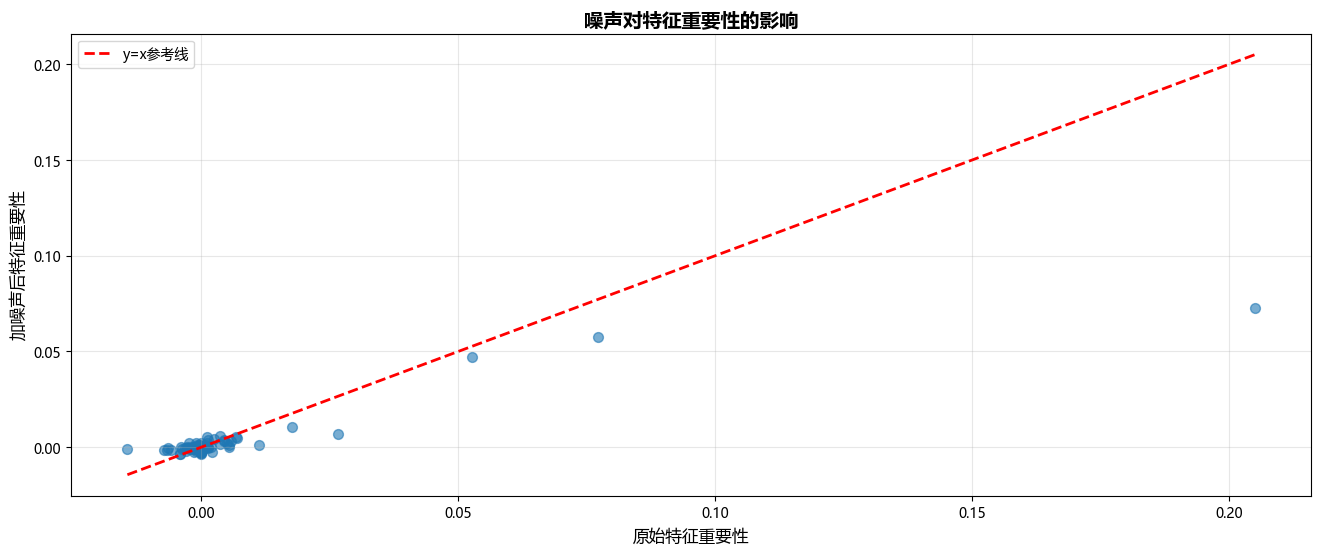

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体和图表风格
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 创建子图 (1行1列)
fig, axes = plt.subplots(1, 1, figsize=(16, 6))

# 1. 散点图:origin vs with_noise
axes.scatter(permutation_feature_importance['origin'], 
                permutation_feature_importance['with_noise'],
                alpha=0.6, s=50)
axes.plot([permutation_feature_importance['origin'].min(), 
              permutation_feature_importance['origin'].max()],
             [permutation_feature_importance['origin'].min(), 
              permutation_feature_importance['origin'].max()],
             'r--', lw=2, label='y=x参考线')
axes.set_xlabel('原始特征重要性', fontsize=12)
axes.set_ylabel('加噪声后特征重要性', fontsize=12)
axes.set_title('噪声对特征重要性的影响', fontsize=14, fontweight='bold')
axes.legend()
axes.grid(True, alpha=0.3)
near = permutation_feature_importance[['origin', 'with_multilinear']].corr().iloc[0, 1]

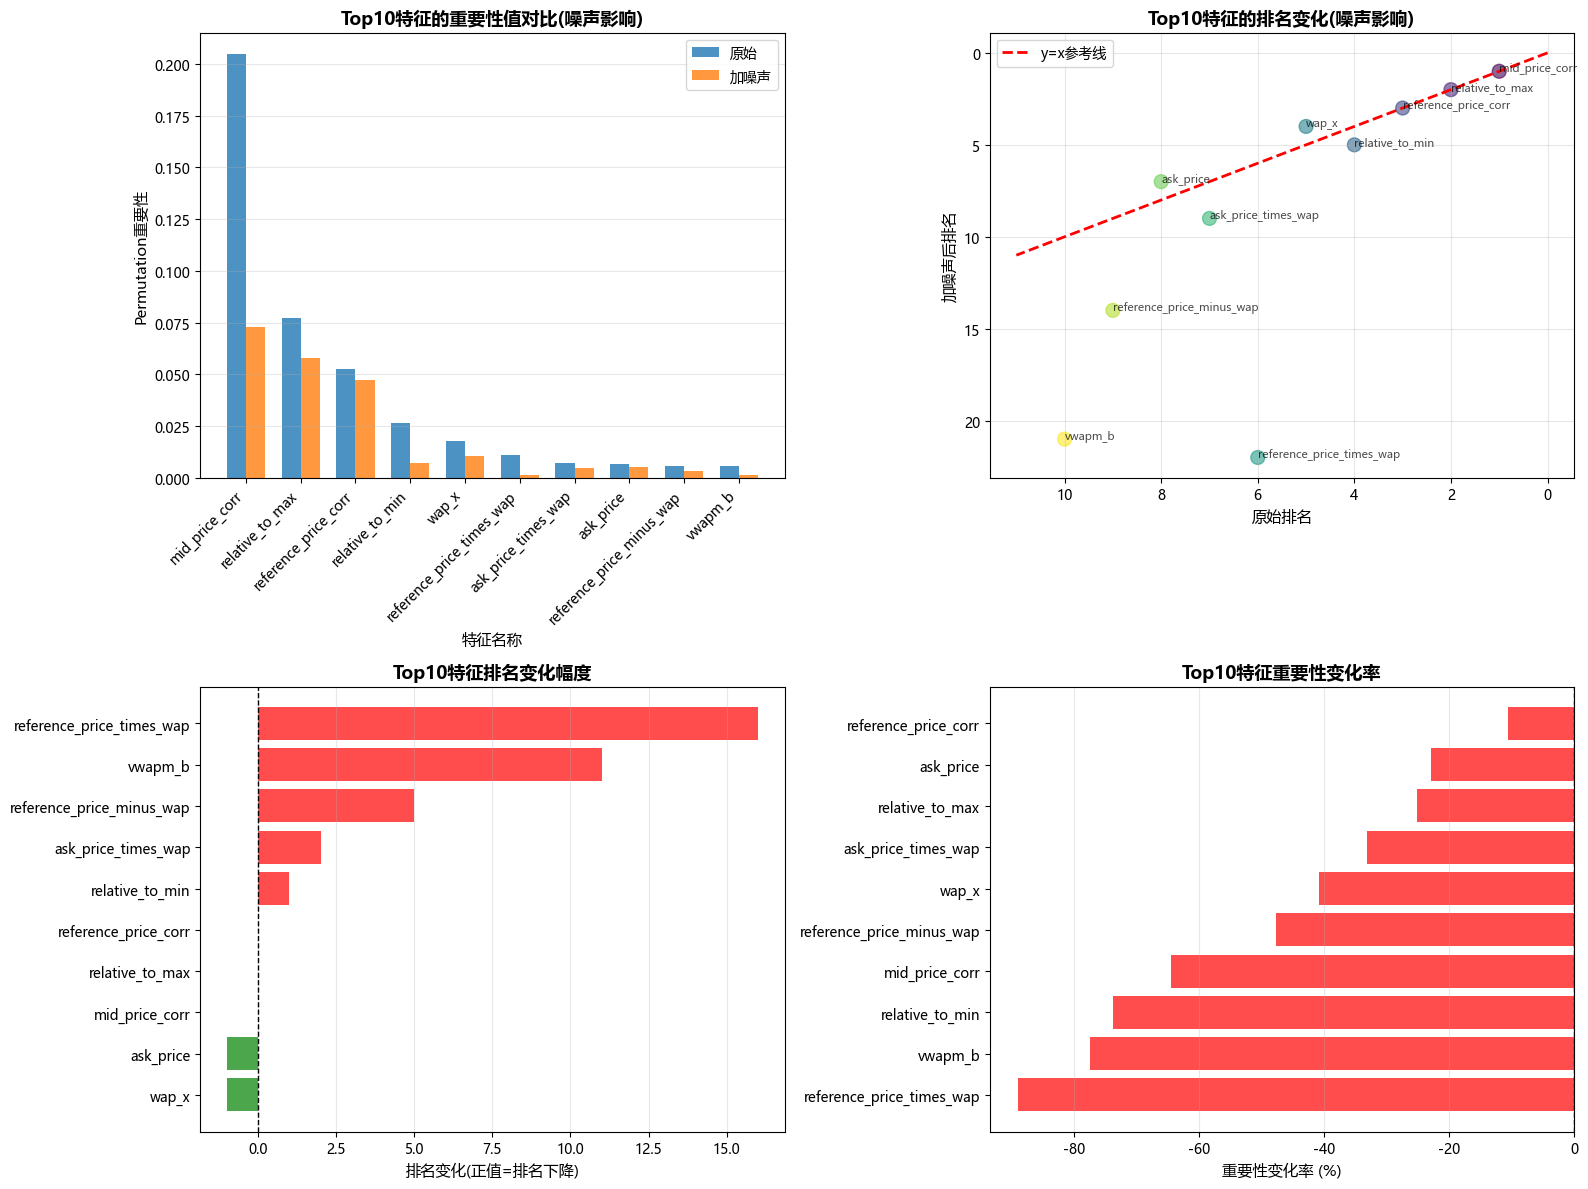

Top10特征在噪声影响下的稳定性分析

排名对比表:
----------------------------------------------------------------------
                           原始排名  加噪声排名  排名变化     原始重要性    加噪声重要性  变化率(%)
mid_price_corr                1      1     0  0.204910  0.072838  -64.45
relative_to_max               2      2     0  0.077191  0.057787  -25.14
reference_price_corr          3      3     0  0.052708  0.047148  -10.55
relative_to_min               4      5     1  0.026661  0.006992  -73.77
wap_x                         5      4    -1  0.017737  0.010495  -40.83
reference_price_times_wap     6     22    16  0.011192  0.001231  -89.00
ask_price_times_wap           7      9     2  0.006992  0.004674  -33.15
ask_price                     8      7    -1  0.006844  0.005280  -22.86
reference_price_minus_wap     9     14     5  0.005786  0.003031  -47.60
vwapm_b                      10     21    11  0.005516  0.001245  -77.44

总体统计:
- 排名变化平均值: 3.30
- 排名变化标准差: 5.77
- 重要性变化率平均值: -48.48%
- 重要性变化率标准差: 26.48%
- 排名保持在Top10的特征数: 

In [10]:
# 看下前10的特征重要性的排名是否被影响 - 聚焦于noise影响

# 获取原始数据中top10的特征
top10_features = permutation_feature_importance['origin'].nlargest(10).index

# 创建排名对比数据
ranking_comparison = pd.DataFrame({
    'origin_rank': permutation_feature_importance['origin'].rank(ascending=False, method='min'),
    'with_noise_rank': permutation_feature_importance['with_noise'].rank(ascending=False, method='min'),
    'origin_value': permutation_feature_importance['origin'],
    'with_noise_value': permutation_feature_importance['with_noise']
})

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top10特征的重要性值对比
top10_data = permutation_feature_importance.loc[top10_features, ['origin', 'with_noise']]
x = np.arange(len(top10_features))
width = 0.35

axes[0, 0].bar(x - width/2, top10_data['origin'], width, label='原始', alpha=0.8)
axes[0, 0].bar(x + width/2, top10_data['with_noise'], width, label='加噪声', alpha=0.8)
axes[0, 0].set_xlabel('特征名称', fontsize=11)
axes[0, 0].set_ylabel('Permutation重要性', fontsize=11)
axes[0, 0].set_title('Top10特征的重要性值对比(噪声影响)', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(top10_features, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Top10特征的排名变化
rank_changes = ranking_comparison.loc[top10_features]
axes[0, 1].scatter(rank_changes['origin_rank'], 
                   rank_changes['with_noise_rank'], 
                   s=100, alpha=0.6, c=range(len(top10_features)), cmap='viridis')
axes[0, 1].plot([0, rank_changes['origin_rank'].max() + 1], 
                [0, rank_changes['origin_rank'].max() + 1], 
                'r--', lw=2, label='y=x参考线')

# 添加特征名称标注
for idx, feature in enumerate(top10_features):
    axes[0, 1].annotate(feature, 
                        (rank_changes.loc[feature, 'origin_rank'], 
                         rank_changes.loc[feature, 'with_noise_rank']),
                        fontsize=8, alpha=0.7)

axes[0, 1].set_xlabel('原始排名', fontsize=11)
axes[0, 1].set_ylabel('加噪声后排名', fontsize=11)
axes[0, 1].set_title('Top10特征的排名变化(噪声影响)', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].invert_xaxis()
axes[0, 1].invert_yaxis()

# 3. 排名变化幅度
rank_changes['rank_diff'] = rank_changes['with_noise_rank'] - rank_changes['origin_rank']
rank_changes_sorted = rank_changes.sort_values('rank_diff')

colors = ['green' if x <= 0 else 'red' for x in rank_changes_sorted['rank_diff']]
axes[1, 0].barh(range(len(rank_changes_sorted)), rank_changes_sorted['rank_diff'], color=colors, alpha=0.7)
axes[1, 0].set_yticks(range(len(rank_changes_sorted)))
axes[1, 0].set_yticklabels(rank_changes_sorted.index, fontsize=10)
axes[1, 0].set_xlabel('排名变化(正值=排名下降)', fontsize=11)
axes[1, 0].set_title('Top10特征排名变化幅度', fontsize=13, fontweight='bold')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. 重要性变化率
importance_change_rate = ((top10_data['with_noise'] - top10_data['origin']) / 
                          (top10_data['origin'] + 1e-10) * 100)
importance_change_rate_sorted = importance_change_rate.sort_values()

colors = ['green' if x >= 0 else 'red' for x in importance_change_rate_sorted]
axes[1, 1].barh(range(len(importance_change_rate_sorted)), 
                importance_change_rate_sorted, 
                color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(importance_change_rate_sorted)))
axes[1, 1].set_yticklabels(importance_change_rate_sorted.index, fontsize=10)
axes[1, 1].set_xlabel('重要性变化率 (%)', fontsize=11)
axes[1, 1].set_title('Top10特征重要性变化率', fontsize=13, fontweight='bold')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# 输出详细统计
print("=" * 70)
print("Top10特征在噪声影响下的稳定性分析")
print("=" * 70)
print("\n排名对比表:")
print("-" * 70)
comparison_table = pd.DataFrame({
    '原始排名': ranking_comparison.loc[top10_features, 'origin_rank'].astype(int),
    '加噪声排名': ranking_comparison.loc[top10_features, 'with_noise_rank'].astype(int),
    '排名变化': rank_changes['rank_diff'].astype(int),
    '原始重要性': ranking_comparison.loc[top10_features, 'origin_value'].round(6),
    '加噪声重要性': ranking_comparison.loc[top10_features, 'with_noise_value'].round(6),
    '变化率(%)': importance_change_rate.round(2)
})
print(comparison_table.to_string())

print(f"\n总体统计:")
print(f"- 排名变化平均值: {rank_changes['rank_diff'].mean():.2f}")
print(f"- 排名变化标准差: {rank_changes['rank_diff'].std():.2f}")
print(f"- 重要性变化率平均值: {importance_change_rate.mean():.2f}%")
print(f"- 重要性变化率标准差: {importance_change_rate.std():.2f}%")
print(f"- 排名保持在Top10的特征数: {(ranking_comparison.loc[top10_features, 'with_noise_rank'] <= 10).sum()}/10")

In [11]:
permutation_feature_importance = pd.concat([permutation_feature_importance_series_origin,
                                            permutation_feature_importance_series_with_multilinear],axis=0)
permutation_feature_importance

stock_id                  -0.003026
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size            -0.002333
imbalance_buy_sell_flag    0.000213
                             ...   
mid_price_corr_y           0.008699
far_price_corr_y          -0.000054
near_price_corr_y         -0.001488
reference_price_corr_y     0.011069
far_mid_val_y              0.000000
Length: 453, dtype: float64

In [13]:
# 构建三列对比表:origin, multilinear_x, multilinear_y
permutation_feature_importance_comparison = pd.DataFrame({
    'origin': permutation_feature_importance_series_origin,
    'multilinear_x': permutation_feature_importance_series_with_multilinear.iloc[:151].values,
    'multilinear_y': permutation_feature_importance_series_with_multilinear.iloc[151:].values
}, index=permutation_feature_importance_series_origin.index)

permutation_feature_importance_comparison

,origin,multilinear_x,multilinear_y
stock_id,-0.003026,-0.001349,-0.001047
date_id,0.000000,0.000000,0.000000
seconds_in_bucket,0.000000,0.000000,-0.000125
imbalance_size,-0.002333,-0.002784,-0.000627
imbalance_buy_sell_flag,0.000213,0.000000,0.000401
...,...,...,...
mid_price_corr,0.204910,0.108619,0.008699
far_price_corr,-0.003089,0.000556,-0.000054
near_price_corr,-0.001390,-0.001400,-0.001488
reference_price_corr,0.052708,0.020376,0.011069


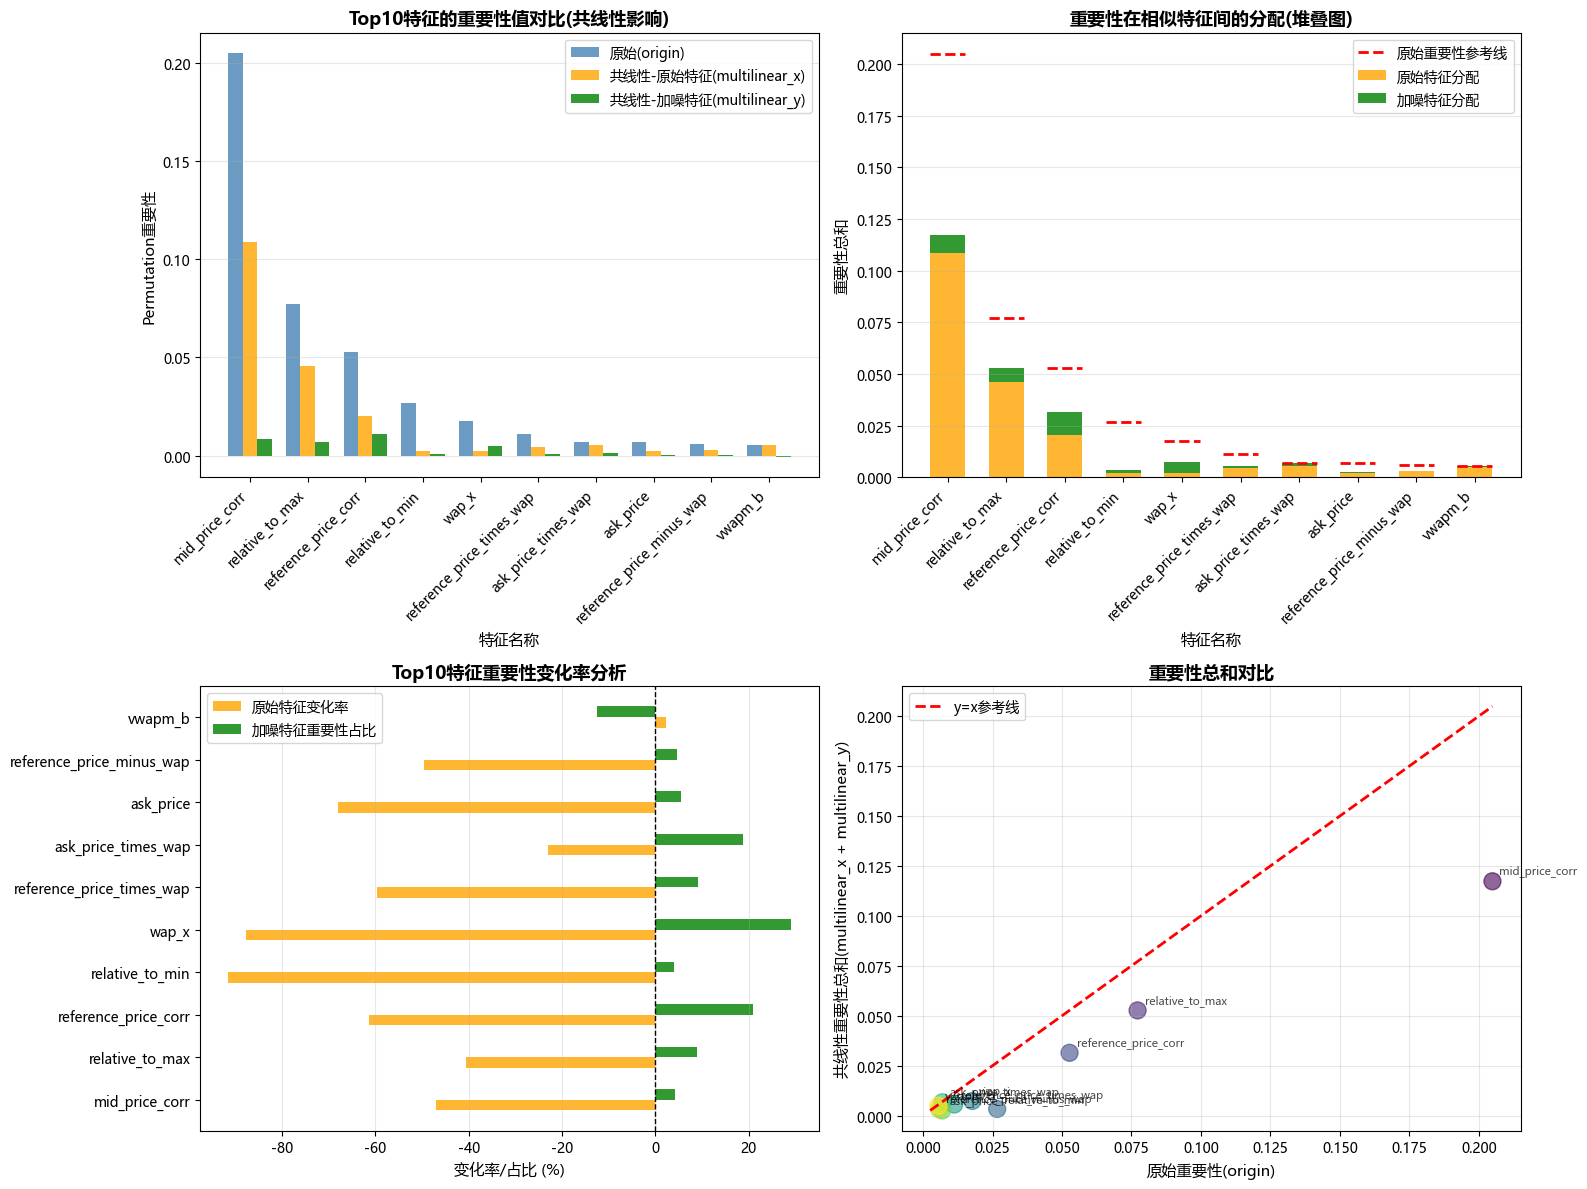

Top10特征在共线性影响下的重要性分配分析

重要性对比表:
--------------------------------------------------------------------------------
                             origin  multilinear_x  multilinear_y     x+y总和  x变化率(%)  y占origin(%)  x占总和(%)
mid_price_corr             0.204910       0.108619       0.008699  0.117318   -46.99         4.25    92.58
relative_to_max            0.077191       0.045852       0.006821  0.052673   -40.60         8.84    87.05
reference_price_corr       0.052708       0.020376       0.011069  0.031445   -61.34        21.00    64.80
relative_to_min            0.026661       0.002254       0.001081  0.003335   -91.55         4.06    67.58
wap_x                      0.017737       0.002179       0.005142  0.007321   -87.71        28.99    29.77
reference_price_times_wap  0.011192       0.004518       0.001016  0.005534   -59.63         9.08    81.64
ask_price_times_wap        0.006992       0.005388       0.001307  0.006695   -22.95        18.69    80.48
ask_price                  0.00

In [14]:
# 画出origin top10在multilinear_x中和multilinear_y中的重要性对比

# 获取origin中top10的特征
top10_features = permutation_feature_importance_comparison['origin'].nlargest(10).index

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top10特征的重要性值对比(三列柱状图)
top10_data = permutation_feature_importance_comparison.loc[top10_features]
x = np.arange(len(top10_features))
width = 0.25

axes[0, 0].bar(x - width, top10_data['origin'], width, label='原始(origin)', alpha=0.8, color='steelblue')
axes[0, 0].bar(x, top10_data['multilinear_x'], width, label='共线性-原始特征(multilinear_x)', alpha=0.8, color='orange')
axes[0, 0].bar(x + width, top10_data['multilinear_y'], width, label='共线性-加噪特征(multilinear_y)', alpha=0.8, color='green')
axes[0, 0].set_xlabel('特征名称', fontsize=11)
axes[0, 0].set_ylabel('Permutation重要性', fontsize=11)
axes[0, 0].set_title('Top10特征的重要性值对比(共线性影响)', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(top10_features, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. 重要性分配比例(堆叠柱状图)
axes[0, 1].bar(x, top10_data['multilinear_x'], width=0.6, label='原始特征分配', alpha=0.8, color='orange')
axes[0, 1].bar(x, top10_data['multilinear_y'], width=0.6, bottom=top10_data['multilinear_x'], 
               label='加噪特征分配', alpha=0.8, color='green')
# 添加origin参考线
for i, feature in enumerate(top10_features):
    axes[0, 1].plot([i-0.3, i+0.3], 
                    [top10_data.loc[feature, 'origin'], top10_data.loc[feature, 'origin']], 
                    'r--', linewidth=2)
axes[0, 1].plot([], [], 'r--', linewidth=2, label='原始重要性参考线')
axes[0, 1].set_xlabel('特征名称', fontsize=11)
axes[0, 1].set_ylabel('重要性总和', fontsize=11)
axes[0, 1].set_title('重要性在相似特征间的分配(堆叠图)', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(top10_features, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. 重要性变化率
importance_change_x = ((top10_data['multilinear_x'] - top10_data['origin']) / 
                       (top10_data['origin'] + 1e-10) * 100)
importance_change_y = (top10_data['multilinear_y'] / (top10_data['origin'] + 1e-10) * 100)

axes[1, 0].barh(x - width/2, importance_change_x, width, label='原始特征变化率', alpha=0.8, color='orange')
axes[1, 0].barh(x + width/2, importance_change_y, width, label='加噪特征重要性占比', alpha=0.8, color='green')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(top10_features, fontsize=10)
axes[1, 0].set_xlabel('变化率/占比 (%)', fontsize=11)
axes[1, 0].set_title('Top10特征重要性变化率分析', fontsize=13, fontweight='bold')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. 散点图:origin vs (multilinear_x + multilinear_y)
multilinear_sum = top10_data['multilinear_x'] + top10_data['multilinear_y']
axes[1, 1].scatter(top10_data['origin'], multilinear_sum, s=150, alpha=0.6, c=range(len(top10_features)), cmap='viridis')

# 添加y=x参考线
min_val = min(top10_data['origin'].min(), multilinear_sum.min())
max_val = max(top10_data['origin'].max(), multilinear_sum.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x参考线')

# 添加特征名称标注
for idx, feature in enumerate(top10_features):
    axes[1, 1].annotate(feature, 
                        (top10_data.loc[feature, 'origin'], multilinear_sum.iloc[idx]),
                        fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

axes[1, 1].set_xlabel('原始重要性(origin)', fontsize=11)
axes[1, 1].set_ylabel('共线性重要性总和(multilinear_x + multilinear_y)', fontsize=11)
axes[1, 1].set_title('重要性总和对比', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 输出详细统计
print("=" * 80)
print("Top10特征在共线性影响下的重要性分配分析")
print("=" * 80)
print("\n重要性对比表:")
print("-" * 80)
comparison_table = pd.DataFrame({
    'origin': top10_data['origin'].round(6),
    'multilinear_x': top10_data['multilinear_x'].round(6),
    'multilinear_y': top10_data['multilinear_y'].round(6),
    'x+y总和': (top10_data['multilinear_x'] + top10_data['multilinear_y']).round(6),
    'x变化率(%)': importance_change_x.round(2),
    'y占origin(%)': importance_change_y.round(2),
    'x占总和(%)': (top10_data['multilinear_x'] / (top10_data['multilinear_x'] + top10_data['multilinear_y'] + 1e-10) * 100).round(2)
})
print(comparison_table.to_string())

print(f"\n总体统计:")
print(f"- 原始特征平均重要性下降: {importance_change_x.mean():.2f}%")
print(f"- 加噪特征平均获得重要性: {importance_change_y.mean():.2f}%")
print(f"- 重要性总和平均保留率: {(multilinear_sum / top10_data['origin']).mean() * 100:.2f}%")
print(f"- 原始特征在总和中平均占比: {(top10_data['multilinear_x'] / (multilinear_sum + 1e-10)).mean() * 100:.2f}%")

有了多重共线性后，几乎所有的feature的重要性都被稀释了